<a href="https://colab.research.google.com/github/olavmoeller/OSU-Pitching-Graphics/blob/main/Dashboard%20and%20MLB%20Comparison/osu_pitcher_graphics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pitcher Graphics


## Introduction

I have always been fascinated by pitching, by analyzing pitching, and quantifying aspects of pitching. That's why I was so struck by Thomas Nestico's [pitcher summary graphic](https://github.com/tnestico/pitching_summary/tree/main), as it contained a ton of information that I found to be so interesting to view. I used his graphics to get a grasp on how pitchers were doing, and potentially when a breakout was legitimite or based on good luck. When I wanted a baseball stats project to work on, I wanted to see if I could adapt this to work for Oregon State pitchers, and see if I could understand how the code worked and how to generate a graphic like the ones I had seen.

This notebook goes through my process with that task, and then adding a second graphic based on my own ideas for how to evaluate performance, by comparing the pitch metrics of college pitchers to MLB pitchers. The beginning reuses a lot of Thomas's code, but I worked through it to understand how it works, so it is far more than just being copied. Additionally, it is of course set up to work with OSU data.

I wanted to create a notebook documenting my process with labels on each step so that I could easily keep working on it, and also share with others so they could understand how I was getting what I was getting and could find specific parts to improve or change or ask questions about.

I hope you find it informative, and a fun project to view!

## Notebook Setup

### Importing Packages

In [2]:
%cd /content/drive/MyDrive/colab/
!pip install MLB-StatsAPI pybaseball pyfonts google-colab-selenium
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import statsapi
import requests
import pybaseball as pyb
import polars as pl
import re
from PIL import Image
from io import BytesIO
from pyfonts import load_font
from bs4 import BeautifulSoup
import time
import math
import google_colab_selenium as gs
import api_scraper
from api_scraper import MLB_Scrape

/content/drive/MyDrive/colab
  Using cached pybaseball-2.2.7-py3-none-any.whl.metadata (11 kB)
  Using cached google_colab_selenium-1.0.14-py3-none-any.whl.metadata (2.7 kB)
  Using cached PyGithub-2.6.1-py3-none-any.whl.metadata (3.9 kB)
Using cached pybaseball-2.2.7-py3-none-any.whl (426 kB)
Using cached google_colab_selenium-1.0.14-py3-none-any.whl (8.2 kB)
Using cached PyGithub-2.6.1-py3-none-any.whl (410 kB)


### Plot Setup


In [ ]:
stratum = load_font(font_url="https://github.com/ccheney/chromotion/blob/master/assets/fonts/stratum2-medium-webfont.ttf?raw=true")

# Set the theme for seaborn plots
sns.set_theme(style='whitegrid',
              palette='deep',
              font='DejaVu Sans',
              font_scale=1.5,
              color_codes=True,
              rc=None)

plt.rcParams['figure.dpi'] = 300

### PITCH COLORS ###
pitch_colors = {
    ## Fastballs ##
    'FF': {'color': '#FF007D', 'name': '4-Seam Fastball'},
    'FA': {'color': '#FF007D', 'name': 'Fastball'},
    'SI': {'color': '#98165D', 'name': 'Sinker'},
    'FC': {'color': '#BE5FA0', 'name': 'Cutter'},

    ## Offspeed ##
    'CH': {'color': '#F79E70', 'name': 'Changeup'},
    'FS': {'color': '#FE6100', 'name': 'Splitter'},
    'SC': {'color': '#F08223', 'name': 'Screwball'},
    'FO': {'color': '#FFB000', 'name': 'Forkball'},

    ## Sliders ##
    'SL': {'color': '#67E18D', 'name': 'Slider'},
    'ST': {'color': '#1BB999', 'name': 'Sweeper'},
    'SV': {'color': '#376748', 'name': 'Slurve'},

    ## Curveballs ##
    'KC': {'color': '#311D8B', 'name': 'Knuckle Curve'},
    'CU': {'color': '#3025CE', 'name': 'Curveball'},
    'CS': {'color': '#274BFC', 'name': 'Slow Curve'},
    'EP': {'color': '#648FFF', 'name': 'Eephus'},

    ## Others ##
    'KN': {'color': '#867A08', 'name': 'Knuckleball'},
    'PO': {'color': '#472C30', 'name': 'Pitch Out'},
    'UN': {'color': '#9C8975', 'name': 'Unknown'},
}

# Create a dictionary mapping pitch types to their colors
dict_color = dict(zip(pitch_colors.keys(), [pitch_colors[key]['color'] for key in pitch_colors]))

# Create a dictionary mapping pitch types to their names
dict_pitch = dict(zip(pitch_colors.keys(), [pitch_colors[key]['name'] for key in pitch_colors]))


## Data Processing

To begin our data analysis, we must first get data! We will be getting our OSU publicly available data, and MLB seasonlong data as a comparison.

### Importing osu game data

#### Pitcher/Year Selection

For the purpose of this notebook and visualizing each step, we will select a pitcher and year here. When simply looking for the final chart, that can be specified at the end in the pitching summary function.

In [3]:
ex_pitchername = 'Eric Segura'
ex_year = 2024

#### Importing Data

All OSU games in statcast parks exist on MLB's api, with unique game ids. After finding these on the web, I will make them into a dictionary by year to be called upon.

In [4]:
osu_games = {
    2024: [763702,763704,763697,763701],
    2025: [796298,796296,796293,796291,795107,795103,795104,791896,791894,791892]}

Using a data scraper created by Thomas Nestico (see his [github](https://github.com/tnestico)), we will load data using the MLB API, which exists for all games in statcast capable parks. We will also process it a little bit to make it suit our needs.

In [6]:
# Creating a function that can return the full dataframe for any set of games
def get_stat_data(gamelist):
    # Activating the scraper
    scraper = MLB_Scrape()

    # Getting the game data for the requested games, making it a pandas dataframe
    game_data = scraper.get_data(game_list_input=gamelist)
    data_df = scraper.get_data_df(data_list=game_data)
    df = data_df.to_pandas()

    # Adding columns for relevant pitching results
    df['in_zone'] = (df['zone'] < 10)
    df['out_zone'] = (df['zone'] > 10)
    df['chase'] = (df.in_zone==False) & (df.is_swing)

    # Adding a year column
    df['year'] = pd.to_datetime(df['game_date']).dt.year

    # Finding velocity at release point
    df['vy_s'] = -np.sqrt(df['vy0']**2 + 2 * df['ay'] * (60.5 - df['extension'] - df['y0']))
    df['t_s'] = (df['vy0'] - df['vy_s']) / df['ay']
    df['vz_s'] = df['vz0'] - df['az'] * df['t_s']
    df['vx_s'] = df['vx0'] - df['ax'] * df['t_s']

    # Finding actual release point
    df['release_height'] = df['z0'] - df['vz_s'] * df['t_s'] - 0.5 * df['az'] * (df['t_s']**2)
    df['release_side'] = df['x0'] - df['vx_s'] * df['t_s'] - 0.5 * df['ax'] * (df['t_s']**2)

    return df

# Creating a function that gets only pitches thrown by a selected pitcher over a selected year
def player_year_data(playername, year):
    year_df = get_stat_data(osu_games[year])
    return year_df[year_df['pitcher_name'] == playername]

pd_df = player_year_data(ex_pitchername, ex_year)
pd_df.head()

Index(['game_id', 'game_date', 'batter_id', 'batter_name', 'batter_hand',
       'batter_team', 'batter_team_id', 'pitcher_id', 'pitcher_name',
       'pitcher_hand', 'pitcher_team', 'pitcher_team_id', 'ab_number',
       'play_description', 'play_code', 'in_play', 'is_strike', 'is_swing',
       'is_whiff', 'is_out', 'is_ball', 'is_review', 'pitch_type',
       'pitch_description', 'strikes', 'balls', 'outs', 'strikes_after',
       'balls_after', 'outs_after', 'start_speed', 'end_speed', 'sz_top',
       'sz_bot', 'x', 'y', 'ax', 'ay', 'az', 'pfxx', 'pfxz', 'px', 'pz', 'vx0',
       'vy0', 'vz0', 'x0', 'y0', 'z0', 'zone', 'type_confidence', 'plate_time',
       'extension', 'spin_rate', 'spin_direction', 'vb', 'ivb', 'hb',
       'launch_speed', 'launch_angle', 'launch_distance', 'launch_location',
       'trajectory', 'hardness', 'hit_x', 'hit_y', 'index_play', 'play_id',
       'start_time', 'end_time', 'is_pitch', 'type_type', 'type_ab', 'event',
       'event_type', 'rbi', 'away_

#### Processing the data

For showcase purposes, we will filter the data to our selected pitcher, Eric Segura, to show what operations we can do to the data.

In [ ]:
# Aggregating relevant metrics for our OSU pitcher to find pitch classification averages
def gen_grouping(df):
    group_df = df.groupby(['pitcher_name','pitcher_hand','year','pitch_type']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        start_speed = ('start_speed','mean'),  # Average start speed
                        ivb = ('ivb','mean'),  # Average vertical movement
                        hb = ('hb','mean'),  # Average horizontal movement
                        spin_rate = ('spin_rate','mean'),  # Average spin rate
                        spin_axis = ('spin_direction','mean'),  # Average spin axis
                        x0 = ('release_side','mean'),  # Average horizontal release position
                        z0 = ('release_height','mean'),  # Average vertical release position
                        extension = ('extension','mean'),  # Average release extension
                        swing = ('is_swing','sum'),  # Total swings
                        whiff = ('is_whiff','sum'),  # Total whiffs
                        in_zone = ('in_zone','sum'),  # Total in-zone pitches
                        out_zone = ('out_zone','sum'),  # Total out-of-zone pitches
                        chase = ('chase','sum'),  # Total chases
                        ).reset_index()
    return group_df

osu_df = gen_grouping(pd_df)
osu_df

pitcher_name pitcher_hand  year pitch_type  pitch  start_speed        ivb  \
0  Eric Segura            R  2024         CH      7    84.971429  -1.128571   
1  Eric Segura            R  2024         CU     11    79.000000  -3.218182   
2  Eric Segura            R  2024         FF      3    92.766667  13.400000   
3  Eric Segura            R  2024         SI     60    92.308333  10.730000   

          hb    spin_rate   spin_axis        x0        z0  extension swing  \
0  10.971429  1857.714286  255.571429 -2.315174  4.624510   6.755697     4   
1 -16.100000  2253.818182   60.363636 -2.265912  4.839465   6.525305  True   
2   8.466667  2402.333333  236.333333 -2.300708  4.919198   6.354553     0   
3  13.493333  2382.100000  239.800000 -2.378919  4.871607   6.363783    30   

  whiff  in_zone  out_zone  chase  
0  True        2         5      2  
1     0        7         4      0  
2     0        0         3      0  
3    11       36        24      7

### Importing and processing MLB data

Now that we have our OSU data, we need to do the same for MLB for comparisons, through a very similar process. This data will be the same for all potential OSU pitchers, so we can reference it and adjust it now as needed.

In [ ]:
# Importing the data from 2020-2024 mlb pitch level data
mlbpd = pd.read_csv('mlb_pitch_data_2020_2024.csv')

# Adding a year column to the dataframe
mlbpd['year'] = pd.to_datetime(mlbpd['game_date']).dt.year

# Adding columns for relevant pitching results
mlbpd['in_zone'] = (mlbpd['zone'] < 10)
mlbpd['out_zone'] = (mlbpd['zone'] > 10)
mlbpd['chase'] = (mlbpd.in_zone==False) & (mlbpd.is_swing)

# Finding velocity at release point
mlbpd['vy_s'] = -np.sqrt(mlbpd['vy0']**2 + 2 * mlbpd['ay'] * (60.5 - mlbpd['extension'] - mlbpd['y0']))
mlbpd['t_s'] = (mlbpd['vy0'] - mlbpd['vy_s']) / mlbpd['ay']
mlbpd['vz_s'] = mlbpd['vz0'] - mlbpd['az'] * mlbpd['t_s']
mlbpd['vx_s'] = mlbpd['vx0'] - mlbpd['ax'] * mlbpd['t_s']

# Finding actual release point
mlbpd['release_height'] = mlbpd['z0'] - mlbpd['vz_s'] * mlbpd['t_s'] - 0.5 * mlbpd['az'] * (mlbpd['t_s']**2)
mlbpd['release_side'] = mlbpd['x0'] - mlbpd['vx_s'] * mlbpd['t_s'] - 0.5 * mlbpd['ax'] * (mlbpd['t_s']**2)

# Aggregating the relevant metrics for all MLB pitchers by year to account for pitch changes between years
mlbpdall = gen_grouping(mlbpd)

mlbpdall.head()

<ipython-input-169-847035d3b450>:2: DtypeWarning: Columns (15,30,48,72) have mixed types. Specify dtype option on import or set low_memory=False.
  mlbpd = pd.read_csv('mlb_pitch_data_2020_2024.csv')


pitcher_name pitcher_hand  year pitch_type  pitch  start_speed        ivb  \
0   A.J. Alexy            R  2021         CH     77    85.787013  11.810390   
1   A.J. Alexy            R  2021         CU     34    76.170588 -17.170588   
2   A.J. Alexy            R  2021         FF    231    93.312554  19.223810   
3   A.J. Alexy            R  2021         SL     82    80.896341  -1.710976   
4   A.J. Alexy            R  2022         CH     13    88.300000  10.207692   

          hb    spin_rate   spin_axis        x0        z0  extension swing  \
0   7.880519  1487.038961  218.038961 -1.285255  5.896955   6.684640    37   
1  -9.585294  2468.294118   25.529412 -1.026340  6.055686   6.528249     6   
2   4.216450  2217.909091  199.329004 -1.166084  5.989737   6.725396   110   
3  -7.739024  2381.109756   67.024390 -1.224707  5.873778   6.691898    33   
4  10.400000  1503.153846  215.538462 -1.297403  5.894843   6.453773     3   

  whiff  in_zone  out_zone  chase  
0    12       26        51     15  
1     2        9        25      1  
2    18      112       119     25  
3     9       40        42      5  
4  True        2        11      1

## Creating the General Summary Plot

Now that we have all the data we want on the pitch level, we want to create a full summary for each player. I want to first do a very general pitching summary, heavily inspired by and using bits of Thomas Nestico's version, as they convey a lot of information in an easy to read and understand format. To do this, we will have to scrape the OSU roster for some data. We will start by linking to that roster.

For each plot, we will be making them scaleable to call in a general summary command at the end. in a different size.

In [ ]:
# Defining a command that will return our selected pitcher's OSU roster page
def get_player_link(playername, year):
    # URL of the OSU Beavers baseball roster page
    url = 'https://osubeavers.com/sports/baseball/roster/' + str(year) + '/'

    # Defining a function using Selenium to scroll the page, so it loads every player (original URL stops after loading 30)
    driver = gs.Chrome()
    def scroll_and_scrape(url, scroll_pause_time=1):
        driver.get(url)
        # Get scroll height
        last_height = driver.execute_script("return document.body.scrollHeight")
        while True:
            # Scroll down to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            # Wait to load page
            time.sleep(scroll_pause_time)
            # Calculate new scroll height and compare with last scroll height
            new_height = driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height
        # Now that the page is fully scrolled, grab the source
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        return soup
    soup = scroll_and_scrape(url)

    link = url.removesuffix('/sports/baseball/roster/' + str(year) + '/') + soup.find(attrs={"aria-label": re.compile(playername.replace('.',''))})['href']
    return link

# Returning the link with Selenium takes some time, so for this example we will define the link so it is only called once
ex_link = get_player_link(ex_pitchername, ex_year)


# Defining a function that will return our selected pitcher's OSU player ID
def get_player_id(playername, link):
    playername = playername.replace('.','')
    id = link.removeprefix('https://osubeavers.com/sports/baseball/roster/' + playername.lower().split(' ',)[0] + '-' + playername.lower().split(' ',)[1] + '/')
    return id


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Bio information

To make our plot look nice we want to have some biographical info, like a headshot and other player info

#### Headshot

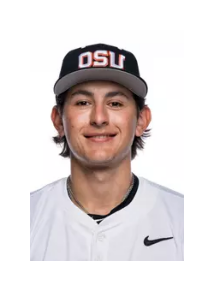

In [ ]:
def get_headshot(link, ax):
    # Using the players link to create a soup object
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Finding the headshot on the page
    pic_link = soup.find(loading="eager", class_="block aspect-[2/3] h-full w-full max-w-[120px] md:max-w-[180px]")['src']
    # Making the headshot a plottable image
    pic_response = requests.get(pic_link)
    img = Image.open(BytesIO(pic_response.content))
    # Creating the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.5)
    ax.imshow(img, extent=[0, 1, 0, 1.5], origin='upper')
    ax.axis('off')

get_headshot(ex_link, ax=plt.subplots(figsize=(1, 1))[1])

#### Short bio

We also want to have a short bio section, with things like name, class, and height highlighted. Additionally, we will have the title for the summary.

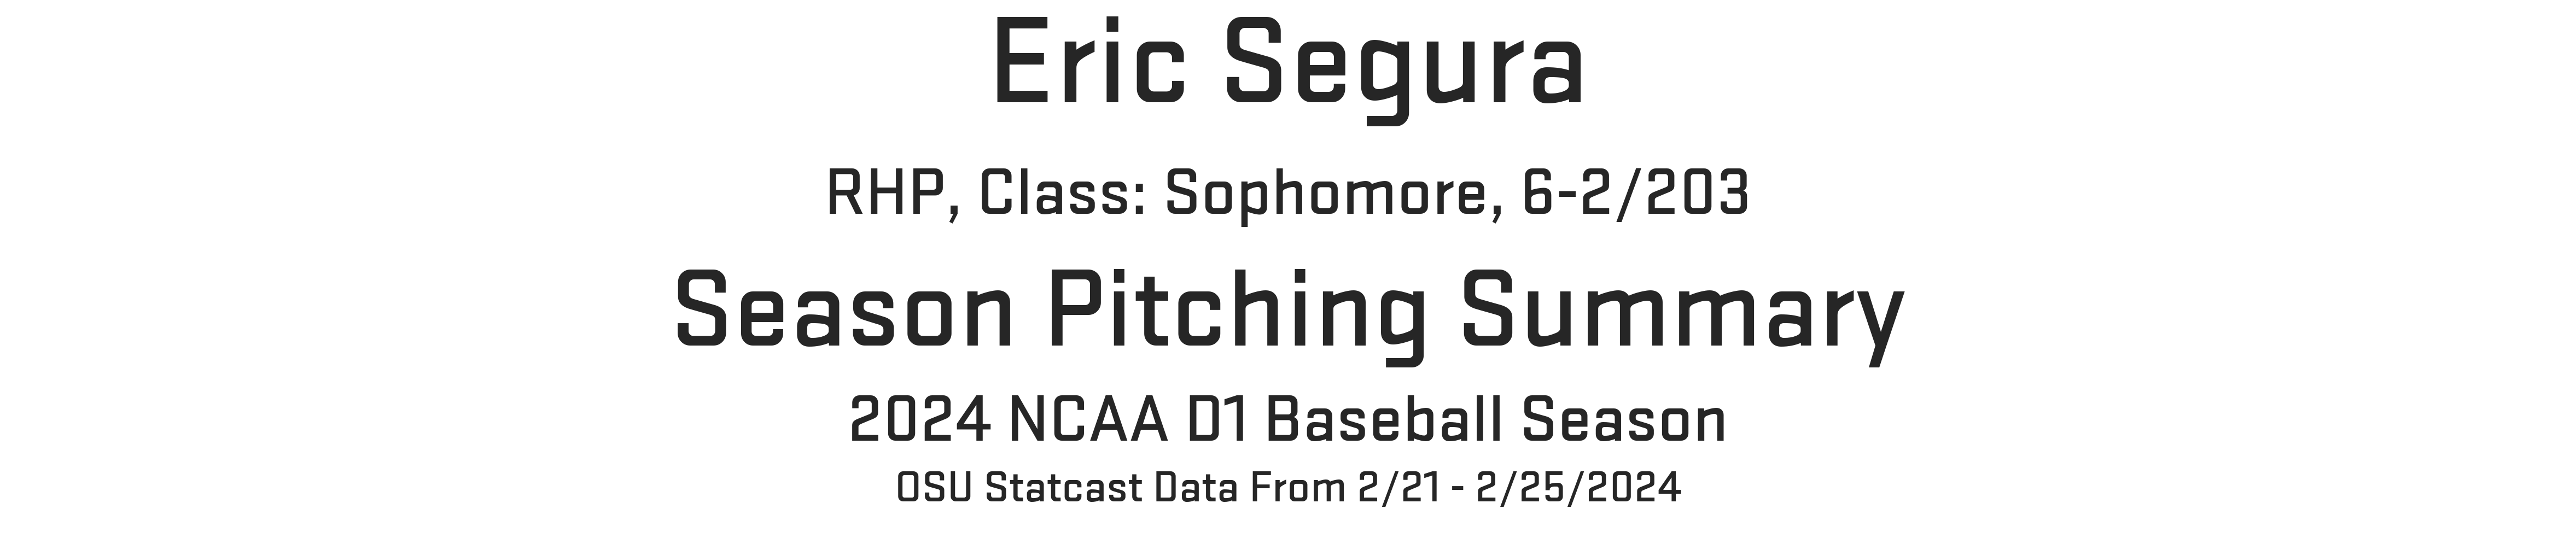

In [ ]:
def player_bio(playername, year, link, ax):
    # Using the players link to create a soup object
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')
    # Determining pitcher handedness
    if soup.find("dt", string="Position: ").find_parent().get_text().split(': ')[1].split('-')[0] == "Right":
      pitcher_hand = 'RHP'
    else:
      pitcher_hand = 'LHP'
    # Calling pitcher class
    pitcher_class = soup.find("dt", string="Class: ").find_parent().get_text()
    # Calling height/weight
    height = soup.find("dt", string="Height: ").find_parent().get_text().split(': ')[1]
    weight = soup.find("dt", string="Weight: ").find_parent().get_text().split(': ')[1]
    # Display the graphic
    ax.text(0.5, 1, f'{playername}', va='top', ha='center', fontsize=56, font=stratum)
    ax.text(0.5, 0.70, f'{pitcher_hand}, {pitcher_class}, {height}/{weight}', va='top', ha='center', fontsize=30, font=stratum)
    ax.text(0.5, 0.50, f'Season Pitching Summary', va='top', ha='center', fontsize=50, font=stratum)
    ax.text(0.5, 0.25, f'{year} NCAA D1 Baseball Season', va='top', ha='center', fontsize=30, fontstyle='italic', font=stratum)
    ax.axis('off')


player_bio(ex_pitchername, ex_year, ex_link, ax=plt.subplots(figsize=(20, 4))[1])

#### OSU Logo

We also want to have the OSU logo displayed, so its very obvious who our pitcher plays for, and this matches with many MLB graphics

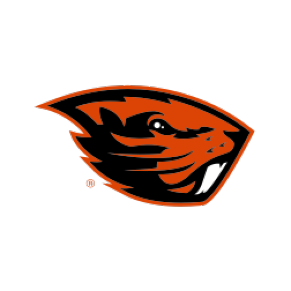

In [ ]:
def logo(ax):
    # Using the logo from the baseball website, but storing it here so we don't have to scrape as it will be the same for each player
    logo_link = 'https://dxbhsrqyrr690.cloudfront.net/sidearm.nextgen.sites/oregonstate.sidearmsports.com/images/logos/site/site.png'
    # Making the logo a plottable image
    logo_response = requests.get(logo_link)
    img = Image.open(BytesIO(logo_response.content))
    # Creating the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')
    ax.axis('off')

logo(ax=plt.subplots(figsize=(1, 1))[1])

### Plots to show on general graphic

We also want to include some plots about pitch data, based on our stacast data.

#### Short form plot


This plot shows pitch movement, based on the pitchers perspective, in IVB and HB.

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  2.70iteration/s]


Converting Data to Dataframe.


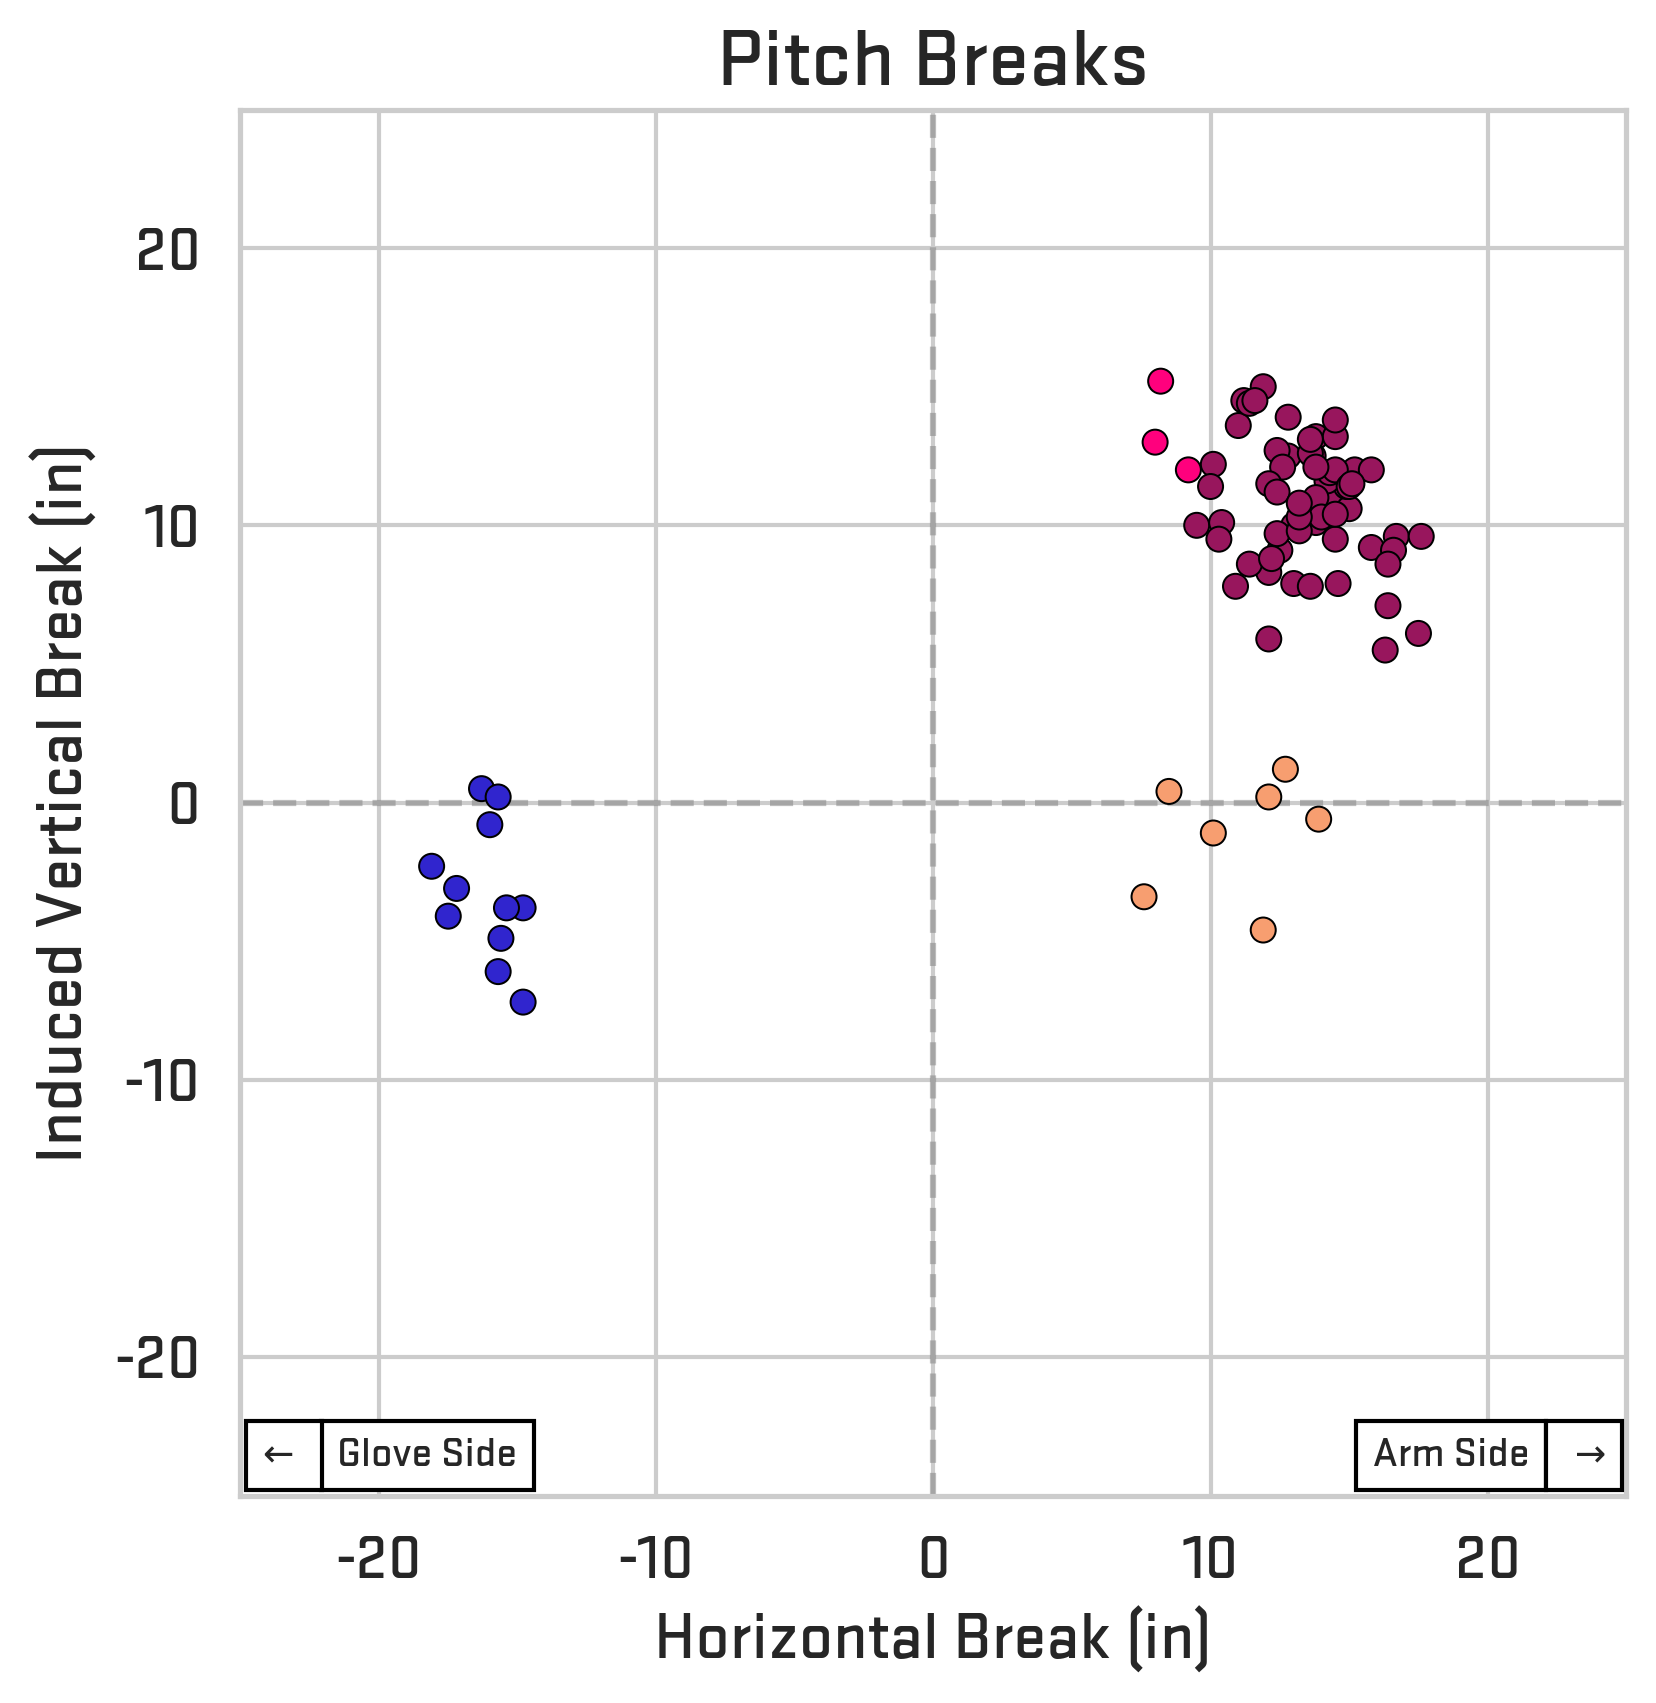

In [ ]:
def break_plot(playername, year, ax):
    # Defining our dataframe by the selected pitcher
    df = player_year_data(playername, year)

    # Check if the pitcher throws with the right hand
    if df['pitcher_hand'].values[0] == 'R':
        sns.scatterplot(ax=ax,
                        x=df['hb'],
                        y=df['ivb'],
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=2)

    # Check if the pitcher throws with the left hand
    if df['pitcher_hand'].values[0] == 'L':
        sns.scatterplot(ax=ax,
                        x=df['hb']*-1,
                        y=df['ivb'],
                        hue=df['pitch_type'],
                        palette=dict_color,
                        ec='black',
                        alpha=1,
                        zorder=2)

    # Draw horizontal and vertical lines at y=0 and x=0 respectively
    ax.axhline(y=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)
    ax.axvline(x=0, color='#808080', alpha=0.5, linestyle='--', zorder=1)

    # Set the labels for the x and y axes
    ax.set_xlabel('Horizontal Break (in)', font=stratum, fontsize=16)
    ax.set_ylabel('Induced Vertical Break (in)', font=stratum, fontsize=16)

    # Set the title of the plot
    ax.set_title("Pitch Breaks", font=stratum, fontsize=20)

    # Remove the legend
    ax.get_legend().remove()

    # Set the tick positions and labels for the x and y axes
    ax.set_xticks(range(-20, 21, 10))
    ax.set_xticklabels(range(-20, 21, 10), font=stratum, fontsize=15)
    ax.set_yticks(range(-20, 21, 10))
    ax.set_yticklabels(range(-20, 21, 10), font=stratum, fontsize=15)

    # Set the limits for the x and y axes
    ax.set_xlim((-25, 25))
    ax.set_ylim((-25, 25))

    # Add text annotations based on the pitcher's throwing hand
    if df['pitcher_hand'].values[0] == 'R':
        ax.text(-21.5, -24.2, s='Glove Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-24.2, -24.2, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(21.5, -24.2, s='Arm Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(22.7, -24.2, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    if df['pitcher_hand'].values[0] == 'L':
        ax.invert_xaxis()
        ax.text(21.5, -24.2, s='Arm Side', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(24.2, -24.2, s='← ', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)
        ax.text(-21.5, -24.2, s='Glove Side', fontstyle='italic', ha='right', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), font=stratum, fontsize=10, zorder=3)
        ax.text(-22.7, -24.2, s=' →', fontstyle='italic', ha='left', va='bottom',
                bbox=dict(facecolor='white', edgecolor='black'), fontsize=9, zorder=3)

    # Set the aspect ratio of the plot to be equal
    ax.set_aspect('equal', adjustable='box')

    # Format the x and y axis tick labels as integers
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))

break_plot(playername=ex_pitchername, year=ex_year, ax=plt.subplots(figsize=(6, 6))[1])

#### Pitch Sequencing Chart

Now I want to add a chart showing what pitch type our pitcher chooses depending on the count. For example, many pitchers use exclusively a fastball in a 3-0 count, betting on the batter taking. This could show what a batter would be predicting the pitcher to throw, as it is often a part of scouting reports.

First we define a couple functions relevant to our chart

In [ ]:
# Defining a function that finds the pitch after any given pitch, and determines whether a strike or ball was thrown if the at bat continued
def after(df, balls, strikes):
    # Calling all pitches in a specified count
    pitch = df[(df['strikes'] == strikes ) & (df['balls'] == balls)].reset_index()
    # Calling the pitch after the original pitch for the specified count
    after_index = [x+1 for x in df[(df['strikes'] == strikes ) & (df['balls'] == balls)].index]
    # If the inning ended on a certain count, the next pitch would be out of our data, as it wasn't by our OSU pitcher. This loop controls for that
    try:
        pitch_after = df.loc[after_index].reset_index()
    except KeyError:
        same_ab_index = [x for x in after_index if x in df.index]
        pitch_after = df.loc[same_ab_index].reset_index()
    ball_after = 0
    strike_after = 0
    # Running a loop to sum up the number of strikes and balls after our selected count
    for x in pitch_after.index:
        if pitch_after['strikes'].loc[x] == pitch_after['balls'].loc[x] == 0:
            pass
        elif pitch_after['strikes'].loc[x] == pitch['strikes'].loc[x] + 1:
            strike_after = strike_after + 1
        elif pitch_after['balls'].loc[x] == pitch['balls'].loc[x] + 1:
            ball_after = ball_after + 1
        else:
            pass
    return pd.DataFrame({'ball': [ball_after], 'strike': [strike_after]})

# Defining a function that plots a pie chart based on a specified count, determining how many of each pitch type was thrown
def pitch_pie(df, balls, strikes, ax):
    # Finding the ratio of each pitch type
    pitch = df[(df['strikes'] == strikes ) & (df['balls'] == balls)]['pitch_type'].value_counts(normalize=True)
    # If the specified count never happened, display a gray pie chart
    if len(pitch) == 0:
        patches, lists = ax.pie([1], colors=['#808080'])
        [p.set_zorder(10) for p in patches]
    # Otherwise, make the pie chart have colors corresponding to each pitch
    else:
        patches, lists = ax.pie(pitch.to_list(), colors=pitch.index.map(dict_color))
        [p.set_zorder(10) for p in patches]
    # Making the titles for each count
    if balls + strikes == 3:
        ax.set_title(f'{balls}-{strikes}', font=stratum, fontsize=20, loc='left')
    else:
        ax.set_title(f'{balls}-{strikes}', font=stratum, fontsize=20)
    ax.axis('equal')


Now we can make the full pitcher plinko chart

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.69iteration/s]


Converting Data to Dataframe.


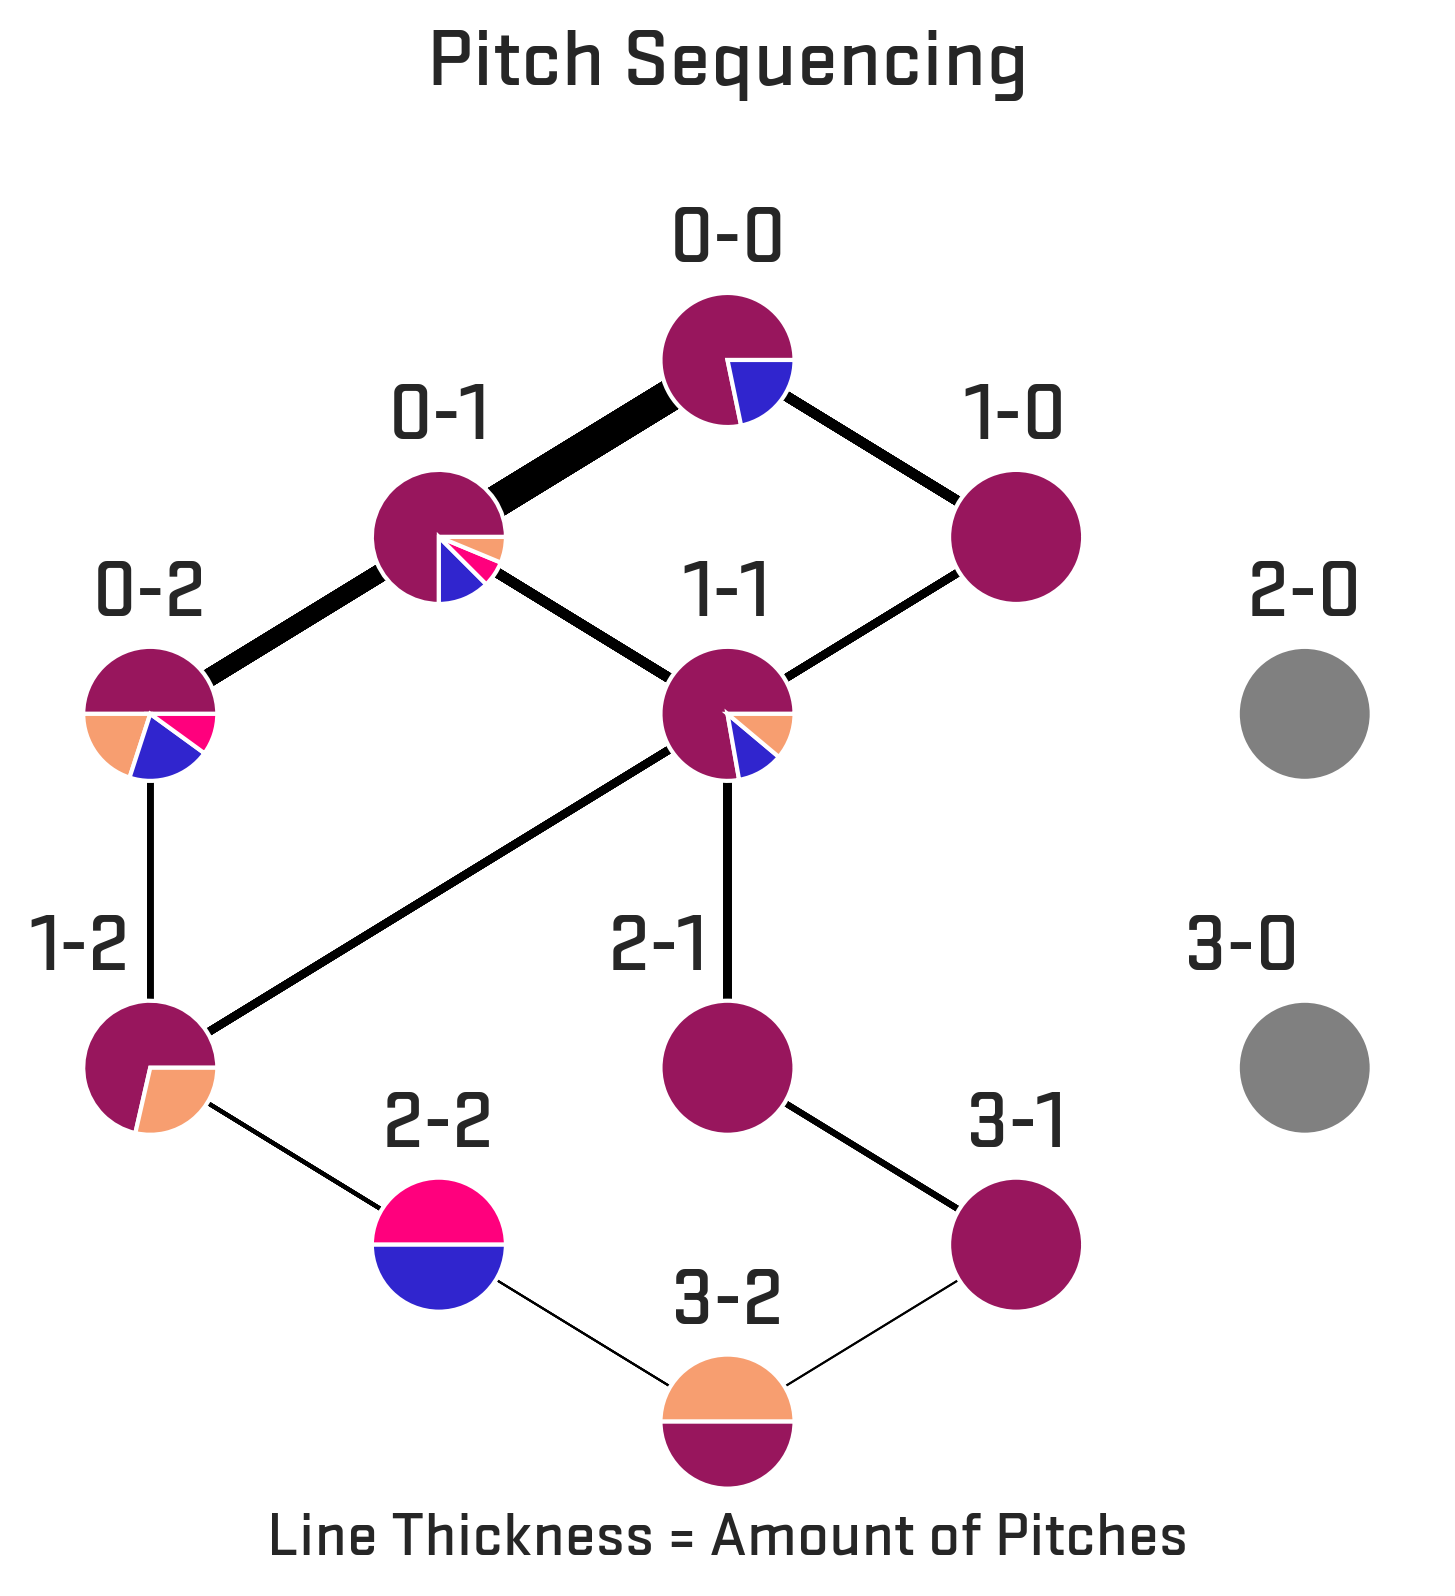

In [ ]:
# Creating the function that calls the chart
def plinko_chart(playername, year, fig, ax, gs, gs_x, gs_y):
    # Assigning our dataframe by relevant pitcher
    df = player_year_data(playername, year)
    # Creating a grid for the pie charts to be placed in
    inner_grid = gridspec.GridSpecFromSubplotSpec(8, 5, subplot_spec=gs[gs_x[0]:gs_x[-1], gs_y[0]:gs_y[-1]])
    # Making a dictionary of where to plot each pie chart
    count_plot_loc = {
        ## Top Row
        (0,0): fig.add_subplot(inner_grid[1, 2]),
        ## Second Row
        (0,1): fig.add_subplot(inner_grid[2, 1]),
        (1,0): fig.add_subplot(inner_grid[2, 3]),
        ## Third Row
        (0,2): fig.add_subplot(inner_grid[3, 0]),
        (1,1): fig.add_subplot(inner_grid[3, 2]),
        (2,0): fig.add_subplot(inner_grid[3, 4]),
        ## Fourth Row
        (1,2): fig.add_subplot(inner_grid[5, 0]),
        (2,1): fig.add_subplot(inner_grid[5, 2]),
        (3,0): fig.add_subplot(inner_grid[5, 4]),
        ## Fifth Row
        (2,2): fig.add_subplot(inner_grid[6, 1]),
        (3,1): fig.add_subplot(inner_grid[6, 3]),
        ## Sixth Row
        (3,2): fig.add_subplot(inner_grid[7, 2])}
    # Defining every possible count
    count_list = [(balls,strikes) for balls in [0,1,2,3] for strikes in [0,1,2]]
    # Creating an empty list that will contain each line between plots
    line_list = []
    # Defining the style of each line
    kw = dict(linestyle="-", color="black", zorder=5)
    # Noting the total number of atbats not ending in the first pitch, as a baseline for how big our lines should be
    tot_abs = after(df,0,0).sum(axis=1,numeric_only=True)[0]
    # Iterating the creation of the pie charts and lines along each possible count
    for (balls, strikes) in count_list:
        pitch_pie(df, balls, strikes, count_plot_loc[(balls,strikes)])
        if (balls,strikes+1) in count_list:
           line_list.append(ConnectionPatch(xyA=(0,0), xyB=(0,0), coordsA=count_plot_loc[(balls,strikes)].transData, coordsB=count_plot_loc[(balls,strikes+1)].transData, **kw, linewidth=10*after(df, balls,strikes)['strike'].loc[0]/tot_abs))
        if (balls+1,strikes) in count_list:
           line_list.append(ConnectionPatch(xyA=(0,0), xyB=(0,0), coordsA=count_plot_loc[(balls,strikes)].transData, coordsB=count_plot_loc[(balls+1,strikes)].transData, **kw, linewidth=10*after(df, balls,strikes)['ball'].loc[0]/tot_abs))
        for line in line_list:
            ax.add_artist(line)
    # Hiding axis text
    ax.axis('off')
    # Setting the title
    ax.set_title('Pitch Sequencing', font=stratum, fontsize=20)
    # Set a label underneath the plot
    count_plot_loc[(3,2)].set_xlabel('Line Thickness = Amount of Pitches',fontsize=15, font=stratum)


fig, ax = plt.subplots(figsize=(6, 6))
plinko_chart(playername=ex_pitchername, year=ex_year, fig=fig, ax=ax, gs=gridspec.GridSpec(1, 1), gs_x=[0, 1], gs_y=[0, 1])

#### Pitch Velocity Histogram

We will add a chart showing the pitcher's velocity among each of their pitch groups, as compared to MLB average, to show how consistantly they retain velocity and what they generally sit at. This also helps our understanding of the short form break plot, as it is time based, meaning slower pitches will have more movement. Since we now know velocity, we can better understand the importance of the break stats.

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.77iteration/s]


Converting Data to Dataframe.


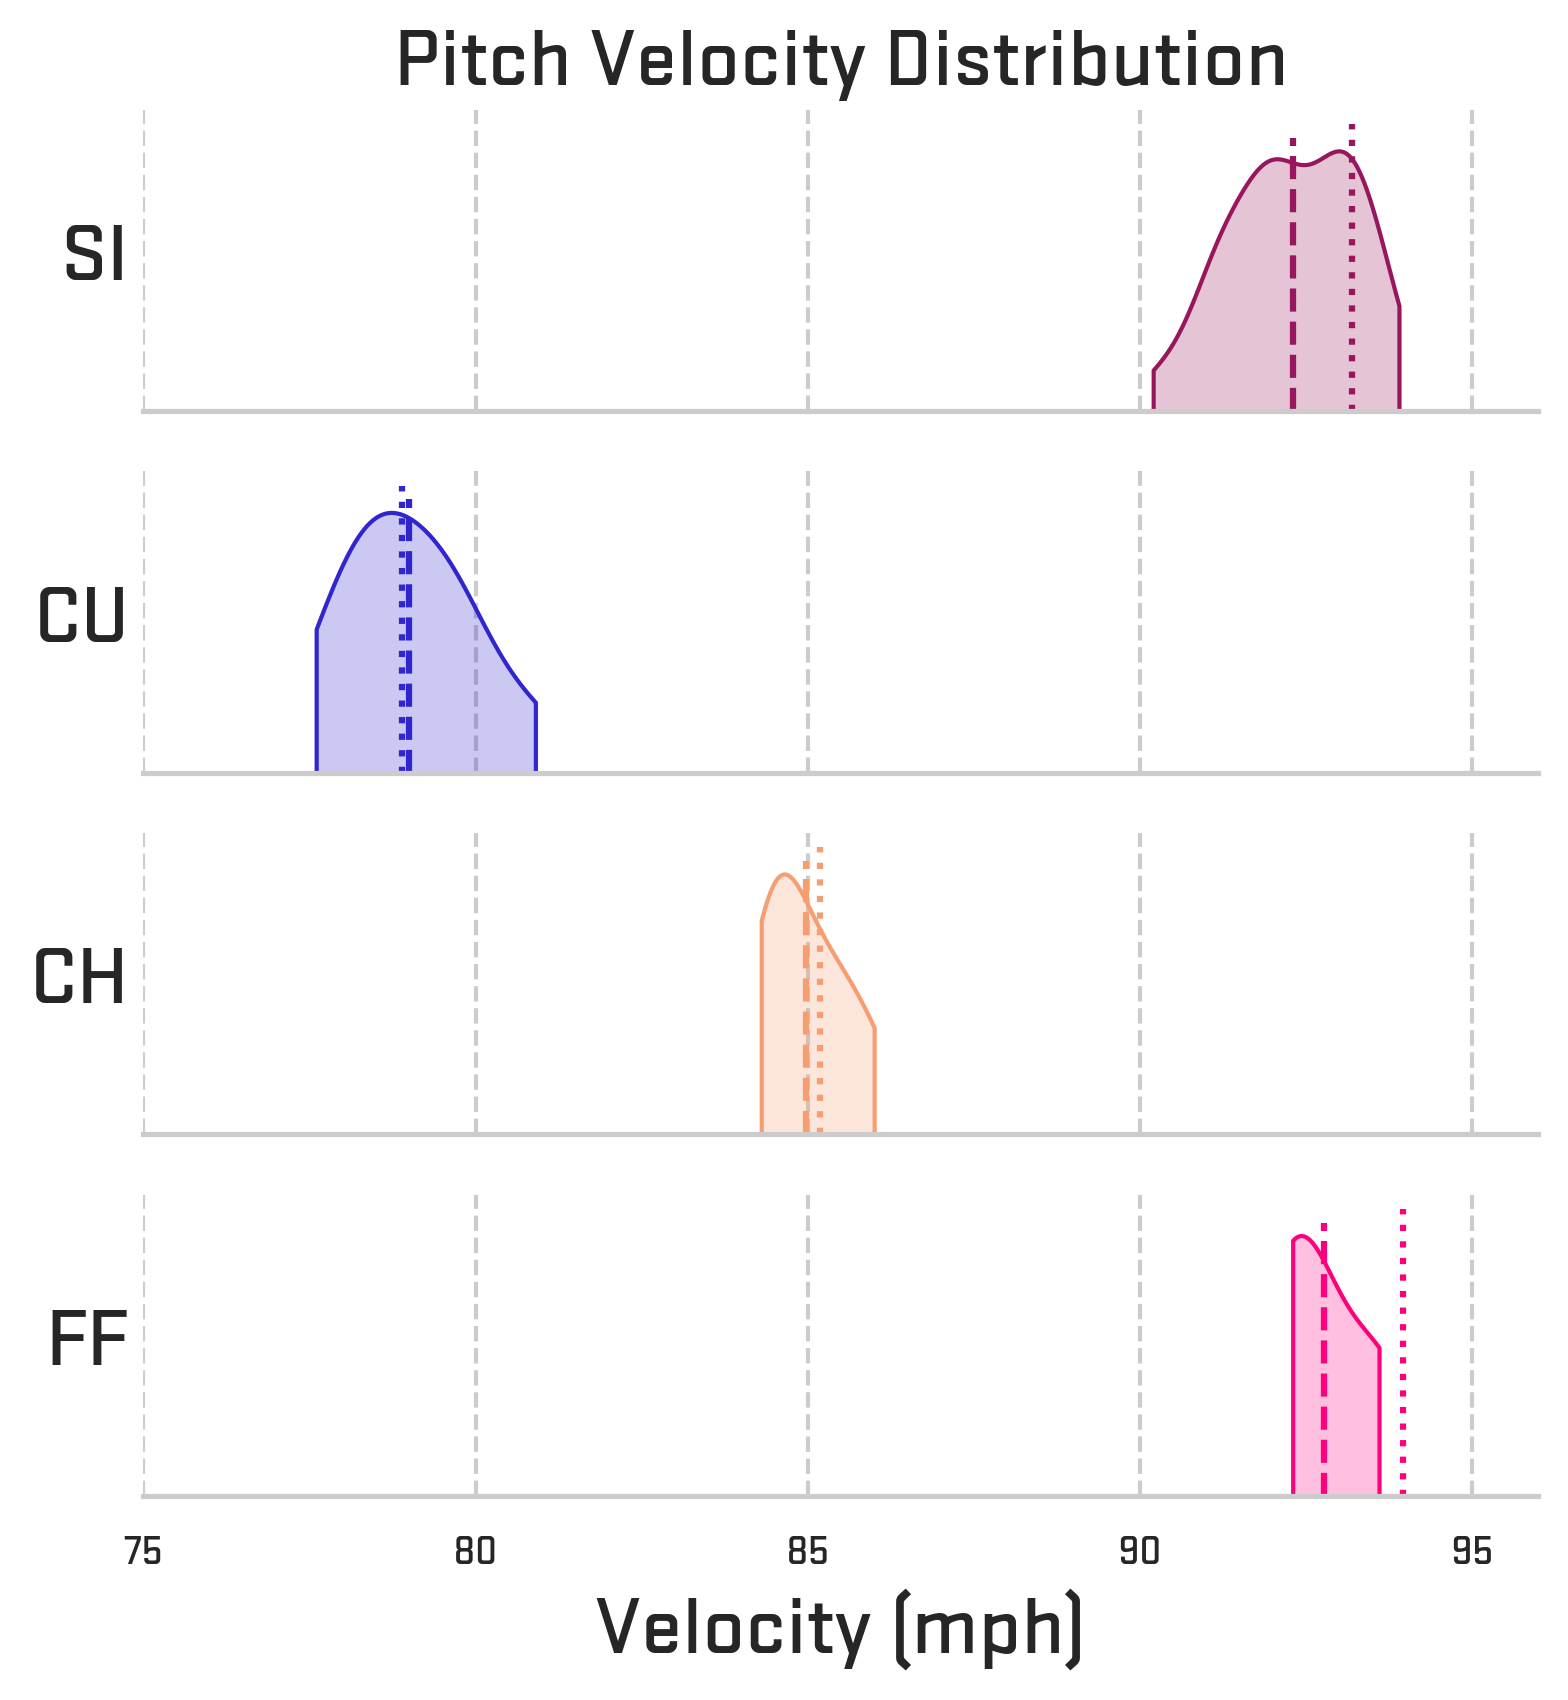

In [ ]:
def velocity_chart(playername, year, fig, ax, gs, gs_x, gs_y):
    # Assigning the dataframe relevant to our selected pitcher
    df = player_year_data(playername, year)

    # Get the count of each pitch type and sort them in descending order
    sorted_value_counts = df['pitch_type'].value_counts().sort_values(ascending=False)

    # Get the list of pitch types ordered from most to least frequent
    items_in_order = sorted_value_counts.index.tolist()

    # Turn off the axis and set the title for the main plot
    ax.axis('off')
    ax.set_title('Pitch Velocity Distribution', font=stratum, fontsize=20)

    # Create a grid for the inner subplots
    inner_grid_1 = gridspec.GridSpecFromSubplotSpec(len(items_in_order), 1, subplot_spec=gs[gs_x[0]:gs_x[-1], gs_y[0]:gs_y[-1]])
    ax_top = []

    # Create subplots for each pitch type
    for inner in inner_grid_1:
        ax_top.append(fig.add_subplot(inner))
    ax_number = 0
    for i in items_in_order:
        # Check if all release speeds for the pitch type are the same
        if np.unique(df[df['pitch_type'] == i]['start_speed']).size == 1:
            # Plot a single line if all values are the same
            ax_top[ax_number].plot([np.unique(df[df['pitch_type'] == i]['start_speed']),
                              np.unique(df[df['pitch_type'] == i]['start_speed'])], [0, 1], linewidth=4,
                              color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]], zorder=20)
        else:
            # Plot the KDE for the release speeds
            sns.kdeplot(df[df['pitch_type'] == i]['start_speed'], ax=ax_top[ax_number], fill=True,
                  clip=(df[df['pitch_type'] == i]['start_speed'].min(), df[df['pitch_type'] == i]['start_speed'].max()),
                  color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]])

        # Plot the mean release speed for the OSU data
        df_average = df[df['pitch_type'] == i]['start_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                      [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                      color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                      linestyle='--')

        # Plot the mean release speed for the 2020-2024 MLB Average Data
        df_average = mlbpd[mlbpd['pitch_type'] == i]['start_speed']
        ax_top[ax_number].plot([df_average.mean(), df_average.mean()],
                      [ax_top[ax_number].get_ylim()[0], ax_top[ax_number].get_ylim()[1]],
                      color=dict_color[df[df['pitch_type'] == i]['pitch_type'].values[0]],
                      linestyle=':')

        # Set the x-axis limits
        ax_top[ax_number].set_xlim(math.floor(df['start_speed'].min() / 5) * 5, math.ceil(df['start_speed'].max() / 5) * 5 + 1)
        ax_top[ax_number].set_xlabel('')
        ax_top[ax_number].set_ylabel('')

        # Hide the top, right, and left spines for all but the last subplot
        if ax_number < len(items_in_order) - 1:
            ax_top[ax_number].spines['top'].set_visible(False)
            ax_top[ax_number].spines['right'].set_visible(False)
            ax_top[ax_number].spines['left'].set_visible(False)
            ax_top[ax_number].tick_params(axis='x', colors='none')

        # Set the x-ticks and y-ticks
        ax_top[ax_number].set_xticks(range(math.floor(df['start_speed'].min() / 5) * 5, math.ceil(df['start_speed'].max() / 5) * 5 + 1, 5))
        ax_top[ax_number].set_yticks([])
        ax_top[ax_number].grid(axis='x', linestyle='--')
        for label in ax_top[ax_number].get_xticklabels():
            label.set_fontproperties(stratum)

        # Add text label for the pitch type
        ax_top[ax_number].text(-0.01, 0.5, i, transform=ax_top[ax_number].transAxes,
                      fontsize=20, va='center', ha='right', font=stratum)
        ax_number += 1

    # Hide the top, right, and left spines for the last subplot
    ax_top[-1].spines['top'].set_visible(False)
    ax_top[-1].spines['right'].set_visible(False)
    ax_top[-1].spines['left'].set_visible(False)

    # Set the x-ticks and x-label for the last subplot
    ax_top[-1].set_xticks(list(range(math.floor(df['start_speed'].min() / 5) * 5, math.ceil(df['start_speed'].max() / 5) * 5 + 1, 5)))
    ax_top[-1].set_xlabel('Velocity (mph)',fontsize=20, font=stratum)



fig, ax = plt.subplots(figsize=(6, 6))
velocity_chart(playername=ex_pitchername, year=ex_year, fig=fig, ax=ax, gs=gridspec.GridSpec(1, 1), gs_x=[0, 1], gs_y=[0, 1])

### Tables for general graphic

We want to add a couple of tables, one containing a season summary, and one containing a pitch metric summary from the data we have.

#### Season Total Data

We want to generate a graphic of our pitcher's seasonlong data, as this is relevant on a summary page even if the data isn't all looked over by statcast, to use as a way to assess their season. Using the lookup functions we made earlier, we will get the stats we are interested in.

In [ ]:
# Defining a function that will turn our player's season stats into a dataframe
def get_player_stats(playername, year, link):
    # Using the osu stats API, with the previous functions to find the player's stats
    response = requests.get('https://osubeavers.com/api/v2/stats/bio?rosterPlayerId=' + get_player_id(playername, link) + '&sport=baseball&year=' + str(year)).json()

    # Converting it to a pandas dataframe with just the total pitching stats
    df = pd.DataFrame(response).loc['pitchingStatsTotal', 'currentStats']

    # Defining factors necessary for the stats table
    hits = int(df['hitsAllowed'])
    walks = int(df['walksAllowed'])
    hbp = int(df['hitBatters'])
    strikeouts = int(df['strikeouts'])
    homeruns = int(df['homeRunsAllowed'])
    outs_recorded = (float(df['inningsPitched'])*10-round(float(df['inningsPitched']),0)*7)
    innings_math = outs_recorded/3

    # Defining the league FIP constant (Based on the PAC-12 in 2024, could be automatic later on with scraping)
    cFIP = 5.31-(((13*663)+(3*(2530+173))-(2*5289))/5465)

    # Creating data table
    stats_data = { 'IP': [df['inningsPitched']],
                  'TBF': [hits+walks+hbp+outs_recorded],
                  'WHIP': [(walks+hits)/innings_math],
                  'ERA': [df['earnedRunAverage']],
                  'FIP': [((13*homeruns)+(3*(walks+hbp))-(2*strikeouts))/innings_math + cFIP]}
    stats_df = pd.DataFrame(stats_data)

    stats_df['K%'] = strikeouts/stats_df['TBF']
    stats_df['BB%'] = walks/stats_df['TBF']
    stats_df['K-BB%'] = stats_df['K%']-stats_df['BB%']
    stats_df = stats_df.astype(float)
    return stats_df

get_player_stats(ex_pitchername, ex_year, ex_link)

IP    TBF      WHIP   ERA       FIP        K%       BB%     K-BB%
0  69.1  304.0  1.283654  4.93  4.530811  0.236842  0.075658  0.161184

Next, we want to process the data slightly so that it is well formatted with decimal points and bolded for the column names. This below is a list of a bunch of stats, not all used in this graphic, with their formatting.

In [ ]:
format_stats_dict = {
    'IP':{'table_header':'$\\bf{IP}$','format':'.1f',} ,
    'TBF':{'table_header':'$\\bf{PA}$','format':'.0f',} ,
    'AVG':{'table_header':'$\\bf{AVG}$','format':'.3f',} ,
    'K/9':{'table_header':'$\\bf{K\/9}$','format':'.2f',} ,
    'BB/9':{'table_header':'$\\bf{BB\/9}$','format':'.2f',} ,
    'K/BB':{'table_header':'$\\bf{K\/BB}$','format':'.2f',} ,
    'HR/9':{'table_header':'$\\bf{HR\/9}$','format':'.2f',} ,
    'K%':{'table_header':'$\\bf{K\%}$','format':'.1%',} ,
    'BB%':{'table_header':'$\\bf{BB\%}$','format':'.1%',} ,
    'K-BB%':{'table_header':'$\\bf{K-BB\%}$','format':'.1%',} ,
    'WHIP':{'table_header':'$\\bf{WHIP}$','format':'.2f',} ,
    'BABIP':{'table_header':'$\\bf{BABIP}$','format':'.3f',} ,
    'LOB%':{'table_header':'$\\bf{LOB\%}$','format':'.1%',} ,
    'xFIP':{'table_header':'$\\bf{xFIP}$','format':'.2f',} ,
    'FIP':{'table_header':'$\\bf{FIP}$','format':'.2f',} ,
    'H':{'table_header':'$\\bf{H}$','format':'.0f',} ,
    '2B':{'table_header':'$\\bf{2B}$','format':'.0f',} ,
    '3B':{'table_header':'$\\bf{3B}$','format':'.0f',} ,
    'R':{'table_header':'$\\bf{R}$','format':'.0f',} ,
    'ER':{'table_header':'$\\bf{ER}$','format':'.0f',} ,
    'HR':{'table_header':'$\\bf{HR}$','format':'.0f',} ,
    'BB':{'table_header':'$\\bf{BB}$','format':'.0f',} ,
    'IBB':{'table_header':'$\\bf{IBB}$','format':'.0f',} ,
    'HBP':{'table_header':'$\\bf{HBP}$','format':'.0f',} ,
    'SO':{'table_header':'$\\bf{SO}$','format':'.0f',} ,
    'OBP':{'table_header':'$\\bf{OBP}$','format':'.0f',} ,
    'SLG':{'table_header':'$\\bf{SLG}$','format':'.0f',} ,
    'ERA':{'table_header':'$\\bf{ERA}$','format':'.2f',} ,
    'wOBA':{'table_header':'$\\bf{wOBA}$','format':'.3f',} ,
    'bWAR':{'table_header':'$\\bf{bWAR}$','format':'.1f',} ,
    'G':{'table_header':'$\\bf{G}$','format':'.0f',} }

Now we just have to create the table itself, with everything formatted as intended.

<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[0] = [format(df[x][0], format_stats_dict[x]['format']) if df[x][0] != '---' else '---' for x in df]
<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '304' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[0] = [format(df[x][0], format_stats_dict[x]['format']) if df[x][0] != '---' else '---' for x in df]
<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.28' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.l

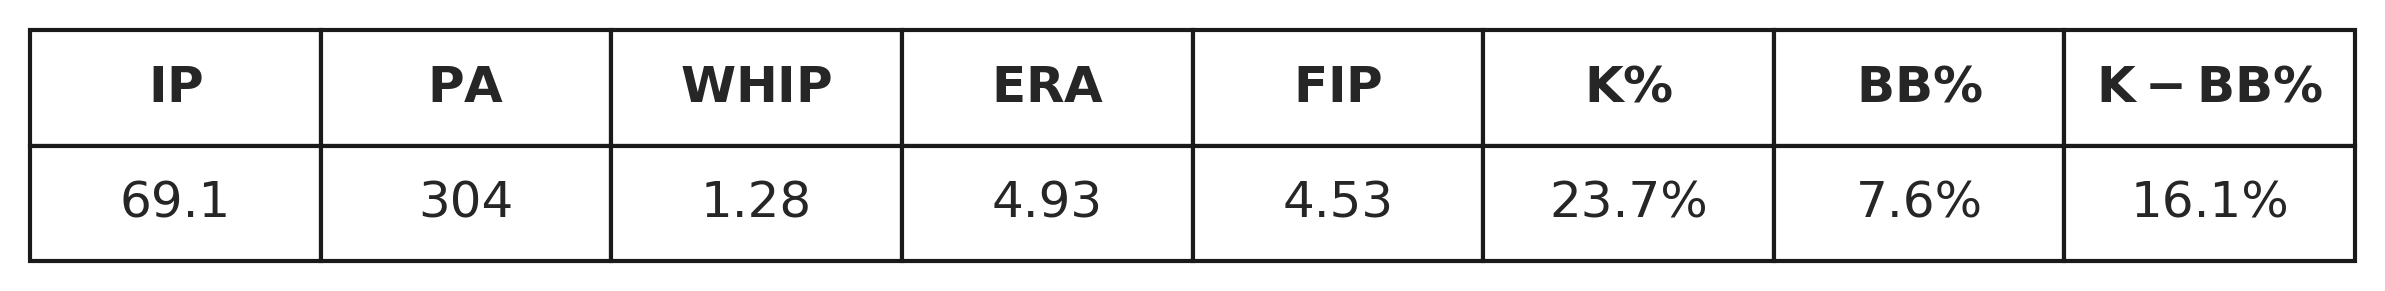

In [ ]:
# A function for the table
def player_stats_table(playername, year, link, ax, fontsize:int=20):
    # calling the dataframe with our stats
    df = get_player_stats(playername, year, link)
    # assigning labels for the table, from the names of the stats
    stats = df.columns.to_list()
    # Formatting the values in the table
    df.loc[0] = [format(df[x][0], format_stats_dict[x]['format']) if df[x][0] != '---' else '---' for x in df]

    # creating the table
    table_fg = ax.table(cellText=df.values, colLabels=stats, cellLoc='center',
                    bbox=[0.00, 0.0, 1, 1])
    # setting font size
    table_fg.set_fontsize(fontsize)
    # hiding axis text
    ax.axis('off')
    # mapping the format to the table
    new_column_names = [format_stats_dict[x]['table_header'] if x in df else '---' for x in stats]
    # #new_column_names = ['Pitch Name', 'Pitch%', 'Velocity', 'Spin Rate','Exit Velocity', 'Whiff%', 'CSW%']
    for i, col_name in enumerate(new_column_names):
        table_fg.get_celld()[(0, i)].get_text().set_text(col_name)

# running the function for Eric Segura
player_stats_table(ex_pitchername, ex_year, ex_link, plt.subplots(figsize=(10, 1))[1])

#### Statcast Pitch Metric Table

Now we want to essentially show the metrics we use for comparing pitches, in a neatly formatted table for each pitch type.

In [ ]:
def table_df(playername, year):
    df = player_year_data(playername, year)
    # Remaking the osu_df dataframe we made earlier, but this allows us to still work with the raw data for averaging
    df_group = gen_grouping(df)

    # Map pitch types to their descriptions
    df_group['pitch_description'] = df_group['pitch_type'].map(dict_pitch)

    # Calculate pitch usage as a percentage of total pitches
    df_group['pitch_usage'] = df_group['pitch'] / df_group['pitch'].sum()

    # Calculate whiff rate as the ratio of whiffs to swings, and have a process in place if there were no swings
    df_group['whiff_rate'] = df_group['whiff'].astype('float') / df_group['swing'].astype('float')

    # Calculate in-zone rate as the ratio of in-zone pitches to total pitches
    df_group['in_zone_rate'] = df_group['in_zone'] / df_group['pitch']

    # Calculate chase rate as the ratio of chases to out-of-zone pitches, with backup in case there were no out of zone pitches
    df_group['chase_rate'] = df_group['chase'] / df_group['out_zone'].astype('float')

    # Map pitch types to their colors
    df_group['color'] = df_group['pitch_type'].map(dict_color)

    # Sort the DataFrame by pitch usage in descending order
    df_group = df_group.sort_values(by='pitch_usage', ascending=False)
    color_list = df_group['color'].tolist()

    # Making a row for totals of each pitch, to have at the bottom of the table
    plot_table_all = pd.DataFrame(data={
                'pitch_type': 'All',
                'pitch_description': 'All',  # Description for the summary row
                'pitch': df['pitch_type'].count(),  # Total count of pitches
                'pitch_usage': 1,  # Usage percentage for all pitches (100%)
                'start_speed': np.nan,  # Placeholder for release speed
                'ivb': np.nan,  # Placeholder for vertical movement
                'hb': np.nan,  # Placeholder for horizontal movement
                'spin_rate': np.nan,  # Placeholder for spin rate
                'x0': np.nan,  # Placeholder for horizontal release position
                'x0': np.nan,  # Placeholder for vertical release position
                'extension': df['extension'].mean(),  # Placeholder for release extension
                'whiff_rate': df['is_whiff'].sum() / df['is_swing'].sum(),  # Whiff rate
                'in_zone_rate': df['in_zone'].sum() / df['pitch_type'].count(),  # In-zone rate
                'chase_rate': df['chase'].sum() / df['out_zone'].sum(),  # Chase rate
            }, index=[0])

    # Merging the group DataFrame with the total row DataFrame
    df_plot = pd.concat([df_group, plot_table_all], ignore_index=True)

    return df_plot, color_list

Like we did with the previous table, we have a formatting guide here that we can use to ensure everything is rounded and formatted correctly.

In [ ]:
pitch_stats_dict = {
    'pitch': {'table_header': '$\\bf{Count}$', 'format': '.0f'},
    'start_speed': {'table_header': '$\\bf{Velocity}$', 'format': '.1f'},
    'ivb': {'table_header': '$\\bf{iVB}$', 'format': '.1f'},
    'hb': {'table_header': '$\\bf{HB}$', 'format': '.1f'},
    'spin_rate': {'table_header': '$\\bf{Spin}$', 'format': '.0f'},
    'x0': {'table_header': '$\\bf{hRel}$', 'format': '.1f'},
    'z0': {'table_header': '$\\bf{vRel}$', 'format': '.1f'},
    'extension': {'table_header': '$\\bf{Ext.}$', 'format': '.1f'},
    'xwoba': {'table_header': '$\\bf{xwOBA}$', 'format': '.3f'},
    'pitch_usage': {'table_header': '$\\bf{Pitch\%}$', 'format': '.1%'},
    'pitch_usage_r': {'table_header': '$\\bf{Pitch\% vs. R}$', 'format': '.1%'},
    'pitch_usage_l': {'table_header': '$\\bf{Pitch\% vs. L}$', 'format': '.1%'},
    'whiff_rate': {'table_header': '$\\bf{Whiff\%}$', 'format': '.1%'},
    'in_zone_rate': {'table_header': '$\\bf{Zone\%}$', 'format': '.1%'},
    'chase_rate': {'table_header': '$\\bf{Chase\%}$', 'format': '.1%'},
    'delta_run_exp_per_100': {'table_header': '$\\bf{RV\//100}$', 'format': '.1f'},
    'spin_axis': {'table_header': '$\\bf{Spin Axis}$', 'format': '.1f'},
    'euclidean': {'table_header': '$\\bf{Euclidean}$', 'format': '.3f'}
    }

table_columns = [ 'pitch_description',
            'pitch',
            'pitch_usage',
            'start_speed',
            'ivb',
            'hb',
            'spin_rate',
            'x0',
            'z0',
            'extension',
            'whiff_rate',
            'in_zone_rate',
            'chase_rate',
            ]

Now we'll make sure that the table is formatted.

In [ ]:
def plot_pitch_format(df, table):
    # Create a DataFrame for the summary row with aggregated statistics for all pitches
    df_group = df[table].fillna('—')

    # Apply the formats to the DataFrame
    # Iterate over each column in pitch_stats_dict
    for column, props in pitch_stats_dict.items():
        # Check if the column exists in df_plot
        if column in df_group.columns:
            # Apply the specified format to the column values
            df_group[column] = df_group[column].apply(lambda x: format(x, props['format']) if isinstance(x, (int, float)) else x)
    return df_group

Now we also want to show how our pitcher's stats compare to other pitches across MLB. We'll compare velocity, extension (as that affects velocity), and also whiff, zone, and chase rates.

In [ ]:
# Defining MLB averages by pitch type
mlbpd_pt_avg = mlbpd.groupby(['pitch_type']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        start_speed = ('start_speed','mean'),  # Average start speed
                        ivb = ('ivb','mean'),  # Average vertical movement
                        hb = ('hb','mean'),  # Average horizontal movement
                        spin_rate = ('spin_rate','mean'),  # Average spin rate
                        x0 = ('release_side','mean'),  # Average horizontal release position
                        z0 = ('release_height','mean'),  # Average vertical release position
                        extension = ('extension','mean'),  # Average release extension
                        swing = ('is_swing','sum'),  # Total swings
                        whiff = ('is_whiff','sum'),  # Total whiffs
                        in_zone = ('in_zone','sum'),  # Total in-zone pitches
                        out_zone = ('out_zone','sum'),  # Total out-of-zone pitches
                        chase = ('chase','sum'),  # Total chases
                        spin_axis = ('spin_direction','mean'),  # Average spin axis
                        ).reset_index()

# Calculate whiff rate as the ratio of whiffs to swings, and have a process in place if there were no swings
mlbpd_pt_avg['whiff_rate'] = mlbpd_pt_avg['whiff'].astype('float') / mlbpd_pt_avg['swing'].astype('float')

# Calculate in-zone rate as the ratio of in-zone pitches to total pitches
mlbpd_pt_avg['in_zone_rate'] = mlbpd_pt_avg['in_zone'] / mlbpd_pt_avg['pitch']

# Calculate chase rate as the ratio of chases to out-of-zone pitches, with backup in case there were no out of zone pitches
mlbpd_pt_avg['chase_rate'] = mlbpd_pt_avg['chase'] / mlbpd_pt_avg['out_zone'].astype('float')

# Add a row at the bottom, for MLB average extension, whiff rate, inzone rate, and chase rate across all pitches
mlbpd_pt_avg_totals = pd.DataFrame(data={
                'pitch_type': 'All',
                'extension': mlbpd['extension'].mean(),  # Placeholder for release extension
                'whiff_rate': mlbpd['is_whiff'].sum() / mlbpd['is_swing'].sum(),  # Whiff rate
                'in_zone_rate': mlbpd_pt_avg['in_zone'].sum() / mlbpd_pt_avg['pitch'].sum(),  # In-zone rate
                'chase_rate': mlbpd_pt_avg['chase'].sum() / mlbpd_pt_avg['out_zone'].sum(),  # Chase rate
            }, index=[0])

# Joining the totals row with the averages database to be used in the code
mlb_averages = pd.concat([mlbpd_pt_avg, mlbpd_pt_avg_totals], ignore_index=True)

Now we will define the color formatting for the table

In [ ]:
# Define color maps
cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#325aa1','#FFFFFF','#c91f26'])
cmap_sum_r = mcolors.LinearSegmentedColormap.from_list("", ['#c91f26','#FFFFFF','#325aa1'])

# List of statistics to color
color_stats = ['start_speed', 'extension', 'whiff_rate', 'in_zone_rate', 'chase_rate']

### get colors ###
def get_color(value, normalize, cmap_sum):
    color = cmap_sum(normalize(value))
    return mcolors.to_hex(color)

def get_cell_colors(df_group: pd.DataFrame,
                     df_statcast_group: pd.DataFrame,
                     color_stats: list,
                     cmap_sum: mcolors.LinearSegmentedColormap,
                     cmap_sum_r: mcolors.LinearSegmentedColormap):
    color_list_df = []
    for pt in df_group.pitch_type.unique():
        color_list_df_inner = []
        select_df = df_statcast_group[df_statcast_group['pitch_type'] == pt]
        df_group_select = df_group[df_group['pitch_type'] == pt]

        for tb in table_columns:

            if tb in color_stats and type(df_group_select[tb].values[0]) == np.float64:
                if np.isnan(df_group_select[tb].values[0]):
                    color_list_df_inner.append('#ffffff')
                elif tb == 'start_speed':
                    normalize = mcolors.Normalize(vmin=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 0.95,
                                                  vmax=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 1.05)
                    color_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))
                else:
                    normalize = mcolors.Normalize(vmin=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 0.7,
                                                  vmax=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 1.3)
                    color_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))
            else:
                color_list_df_inner.append('#ffffff')
        color_list_df.append(color_list_df_inner)
    return color_list_df

Now we want to generate the final pitch metric table

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  2.31iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00,  6.82iteration/s]


Converting Data to Dataframe.


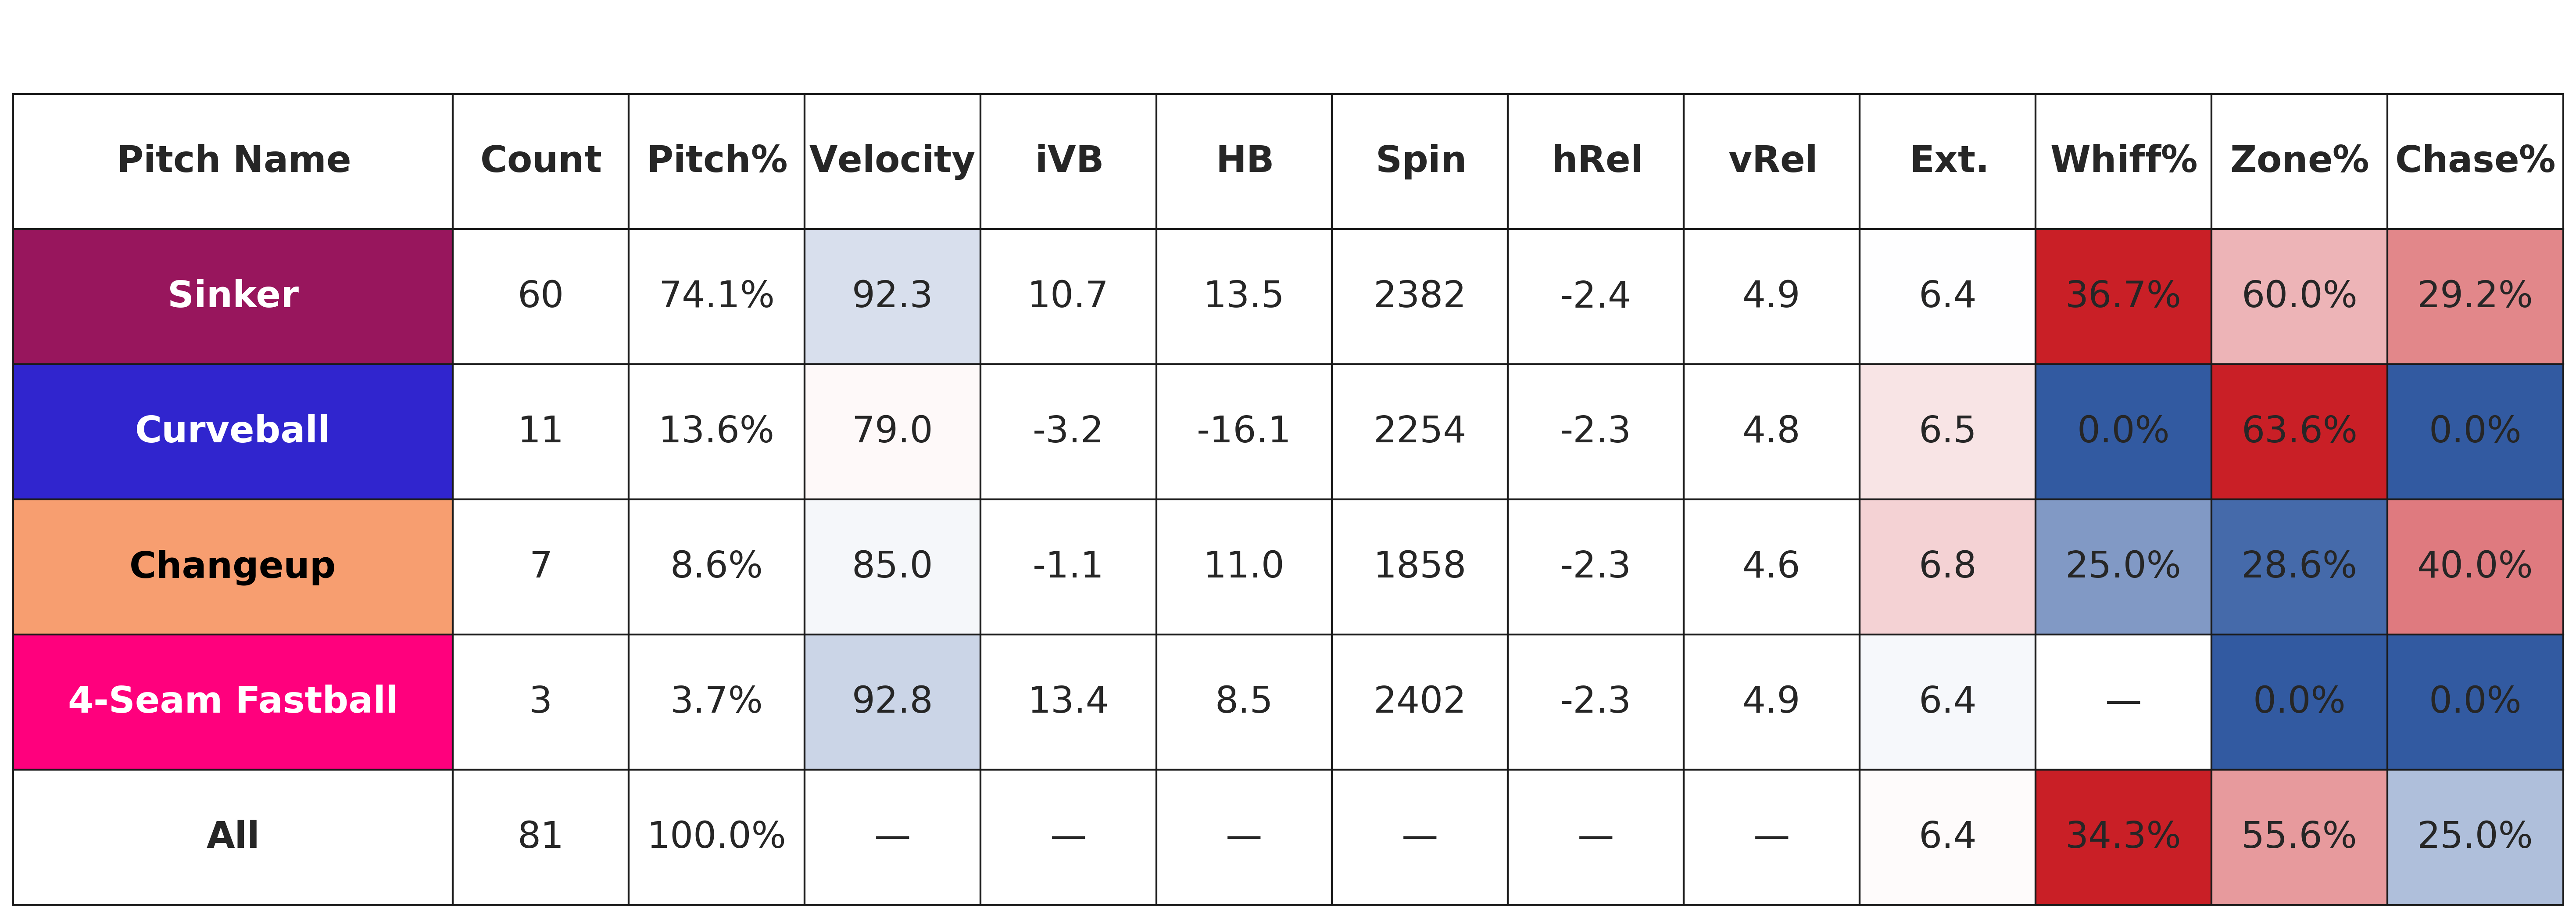

In [ ]:
def pitch_table(playername, year, ax, fontsize:int=20):
    # Defining our dataframe by selected pitcher
    df = player_year_data(playername, year)

    # Defining what table we want for our pitch formatting function
    table = table_columns

    # Performing operations on our dataframe
    df_group, color_list = table_df(playername, year)
    df_plot = plot_pitch_format(df_group, table)
    color_list_df = get_cell_colors(df_group, mlb_averages, color_stats, cmap_sum, cmap_sum_r)

    # Create a table plot with the DataFrame values and specified column labels
    table_plot = ax.table(cellText=df_plot.values, colLabels=table_columns, cellLoc='center',
                        bbox=[0, -0.1, 1, 1],
                        colWidths=[2.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                        cellColours=color_list_df)

    # Disable automatic font size adjustment and set the font size
    table_plot.auto_set_font_size(False)

    table_plot.set_fontsize(fontsize)

    # Scale the table plot
    table_plot.scale(1, 0.5)

    # Correctly format the new column names using LaTeX formatting
    new_column_names = ['$\\bf{Pitch\\ Name}$'] + [pitch_stats_dict[x]['table_header'] if x in pitch_stats_dict else '---' for x in table_columns[1:]]

    # Update the table headers with the new column names
    for i, col_name in enumerate(new_column_names):
        table_plot.get_celld()[(0, i)].get_text().set_text(col_name)

    # Bold the first column in the table
    for i in range(len(df_plot)):
        table_plot.get_celld()[(i+1, 0)].get_text().set_fontweight('bold')

    # Set the color for the first column, all rows except header and last
    for i in range(1, len(df_plot)):
        # Check if the pitch type is in the specified list
        if table_plot.get_celld()[(i, 0)].get_text().get_text() in ['Split-Finger', 'Slider', 'Changeup']:
            table_plot.get_celld()[(i, 0)].set_text_props(color='#000000', fontweight='bold')
        else:
            table_plot.get_celld()[(i, 0)].set_text_props(color='#FFFFFF')
        # Set the background color of the cell
        table_plot.get_celld()[(i, 0)].set_facecolor(color_list[i-1])

    # Remove the axis
    ax.axis('off')

pitch_table(playername=ex_pitchername, year=ex_year, ax = plt.subplots(figsize=(25, 8))[1])

### Final General Summary Plot

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.10iteration/s]


Converting Data to Dataframe.


<IPython.core.display.Javascript object>

<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '69.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[0] = [format(df[x][0], format_stats_dict[x]['format']) if df[x][0] != '---' else '---' for x in df]
<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '304' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[0] = [format(df[x][0], format_stats_dict[x]['format']) if df[x][0] != '---' else '---' for x in df]
<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.28' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.l

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  3.12iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.87iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.87iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.81iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.33iteration/s]


Converting Data to Dataframe.


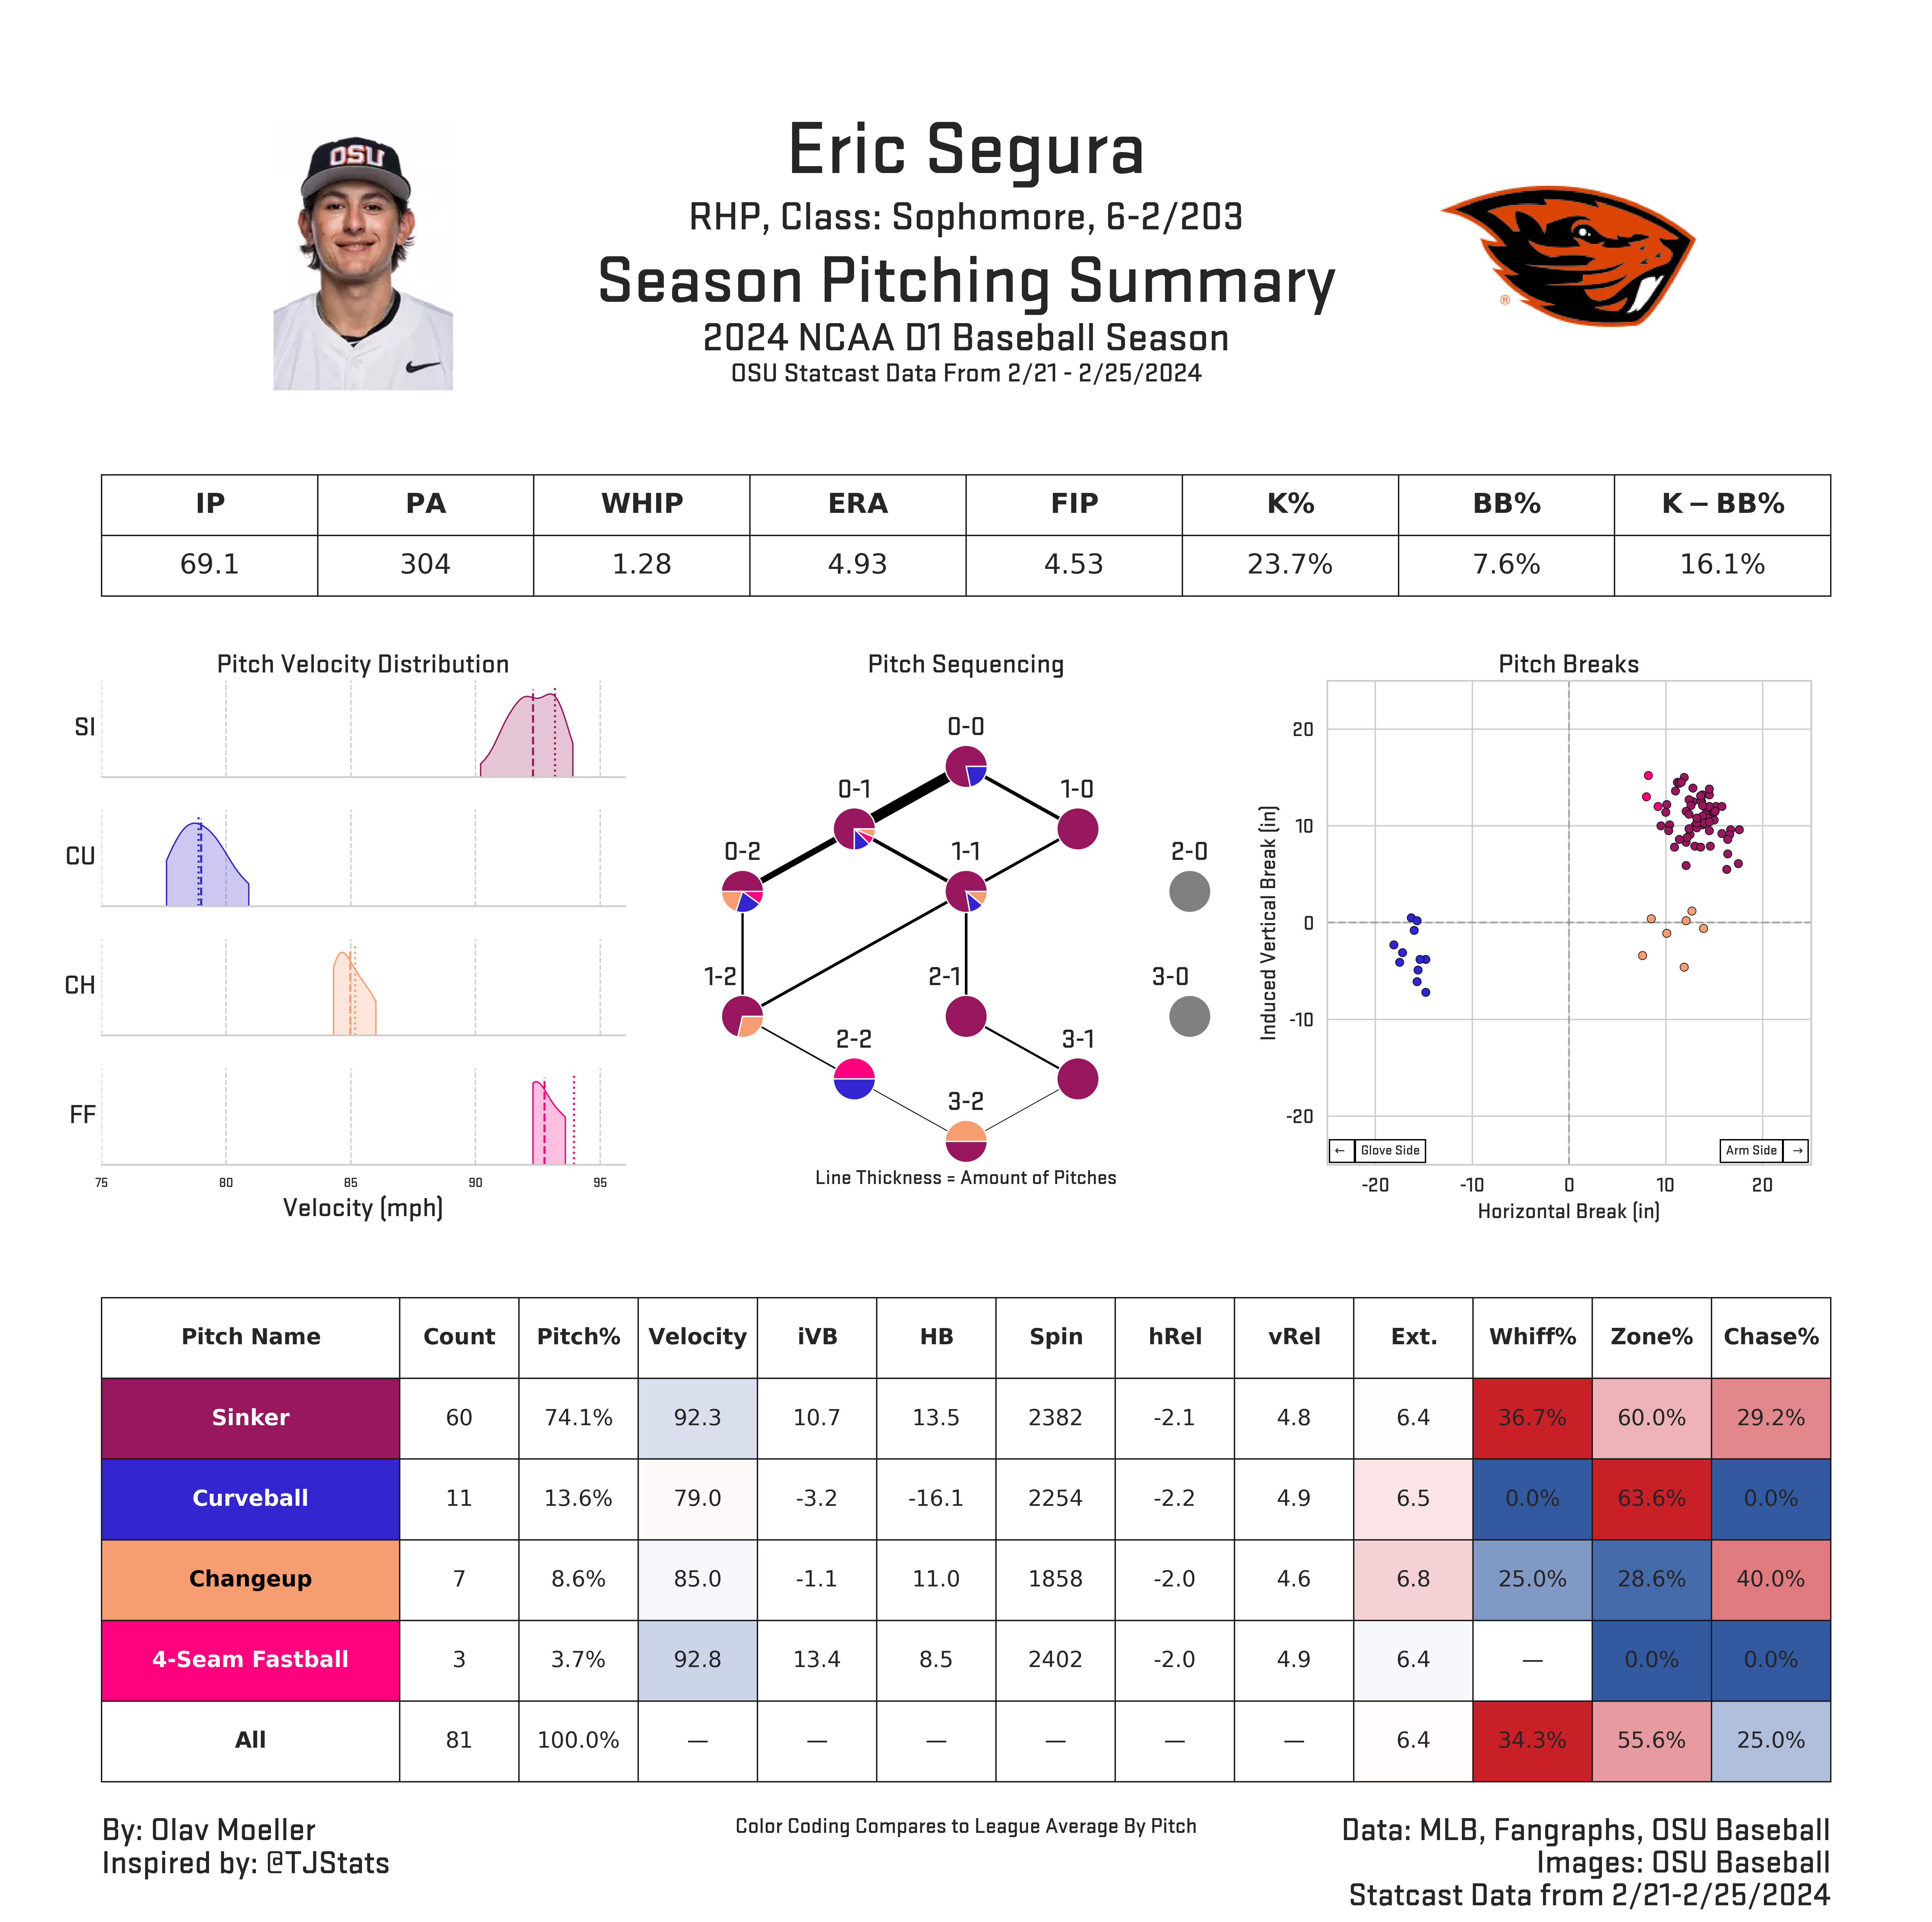

In [ ]:
def pitching_dashboard(playername, year):
    # Create a 20 by 20 figure
    df = player_year_data(playername, year)
    fig = plt.figure(figsize=(20, 20))

    # Create a gridspec layout with 8 columns and 6 rows
    # Include border plots for the header, footer, left, and right
    gs = gridspec.GridSpec(6, 8,
                        height_ratios=[2,20,9,36,36,7],
                        width_ratios=[1,18,18,18,18,18,18,1])

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1,1:3])
    ax_bio = fig.add_subplot(gs[1,3:5])
    ax_logo = fig.add_subplot(gs[1,5:7])

    ax_season_table = fig.add_subplot(gs[2,1:7])

    ax_plot_1 = fig.add_subplot(gs[3,1:3])
    ax_plot_2 = fig.add_subplot(gs[3,3:5])
    ax_plot_3 = fig.add_subplot(gs[3,5:7])

    ax_table = fig.add_subplot(gs[4,1:7])

    ax_footer = fig.add_subplot(gs[-1,1:7])
    ax_header = fig.add_subplot(gs[0,1:7])
    ax_left = fig.add_subplot(gs[:,0])
    ax_right = fig.add_subplot(gs[:,-1])

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Define the player's link that can be called for the functions
    link = get_player_link(playername=playername, year=year)

    # Call the functions
    fontsize = 16
    player_stats_table(playername=playername, year=year, link=link, ax=ax_season_table, fontsize=20)
    pitch_table(playername=playername, year=year, ax=ax_table, fontsize=fontsize)

    get_headshot(link=link, ax=ax_headshot)
    player_bio(playername=playername, year=year, link=link, ax=ax_bio)
    logo(ax=ax_logo)

    velocity_chart(playername=playername, year=year, fig=fig, ax=ax_plot_1, gs=gs, gs_x=[3,4], gs_y=[1,3])
    plinko_chart(playername=playername, year=year, fig=fig, ax=ax_plot_2, gs=gs, gs_x=[3,4], gs_y=[3,5])
    break_plot(playername=playername, year=year, ax=ax_plot_3)

    # Add footer text
    ax_footer.text(0, 1, 'By: Olav Moeller\nInspired by: @TJStats', ha='left', va='top', fontsize=24, font=stratum)
    ax_footer.text(0.5, 1, 'Color Coding Compares to League Average By Pitch', ha='center', va='top', fontsize=16, font=stratum)
    ax_footer.text(1, 1, 'Data: MLB, Fangraphs, OSU Baseball\nImages: OSU Baseball\nStatcast Data from 2/21-2/25/2024', ha='right', va='top', fontsize=24, font=stratum)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Download the graphic as a png with the pitcher's name
    plt.savefig(f"pitching_dashboard_{playername.split(sep=' ')[1]}_{year}.png")


# Call the pitching_dashboard function with the pitcher's name and year
pitching_dashboard(ex_pitchername, ex_year)

Another Example, with Nelson Keljo instead

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  2.95iteration/s]


Converting Data to Dataframe.


<IPython.core.display.Javascript object>

<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '43.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[0] = [format(df[x][0], format_stats_dict[x]['format']) if df[x][0] != '---' else '---' for x in df]
<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '191' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[0] = [format(df[x][0], format_stats_dict[x]['format']) if df[x][0] != '---' else '---' for x in df]
<ipython-input-18-c992b9565598>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.37' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.l

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.09iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  3.71iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00,  7.43iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00,  6.52iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 15.02iteration/s]


Converting Data to Dataframe.


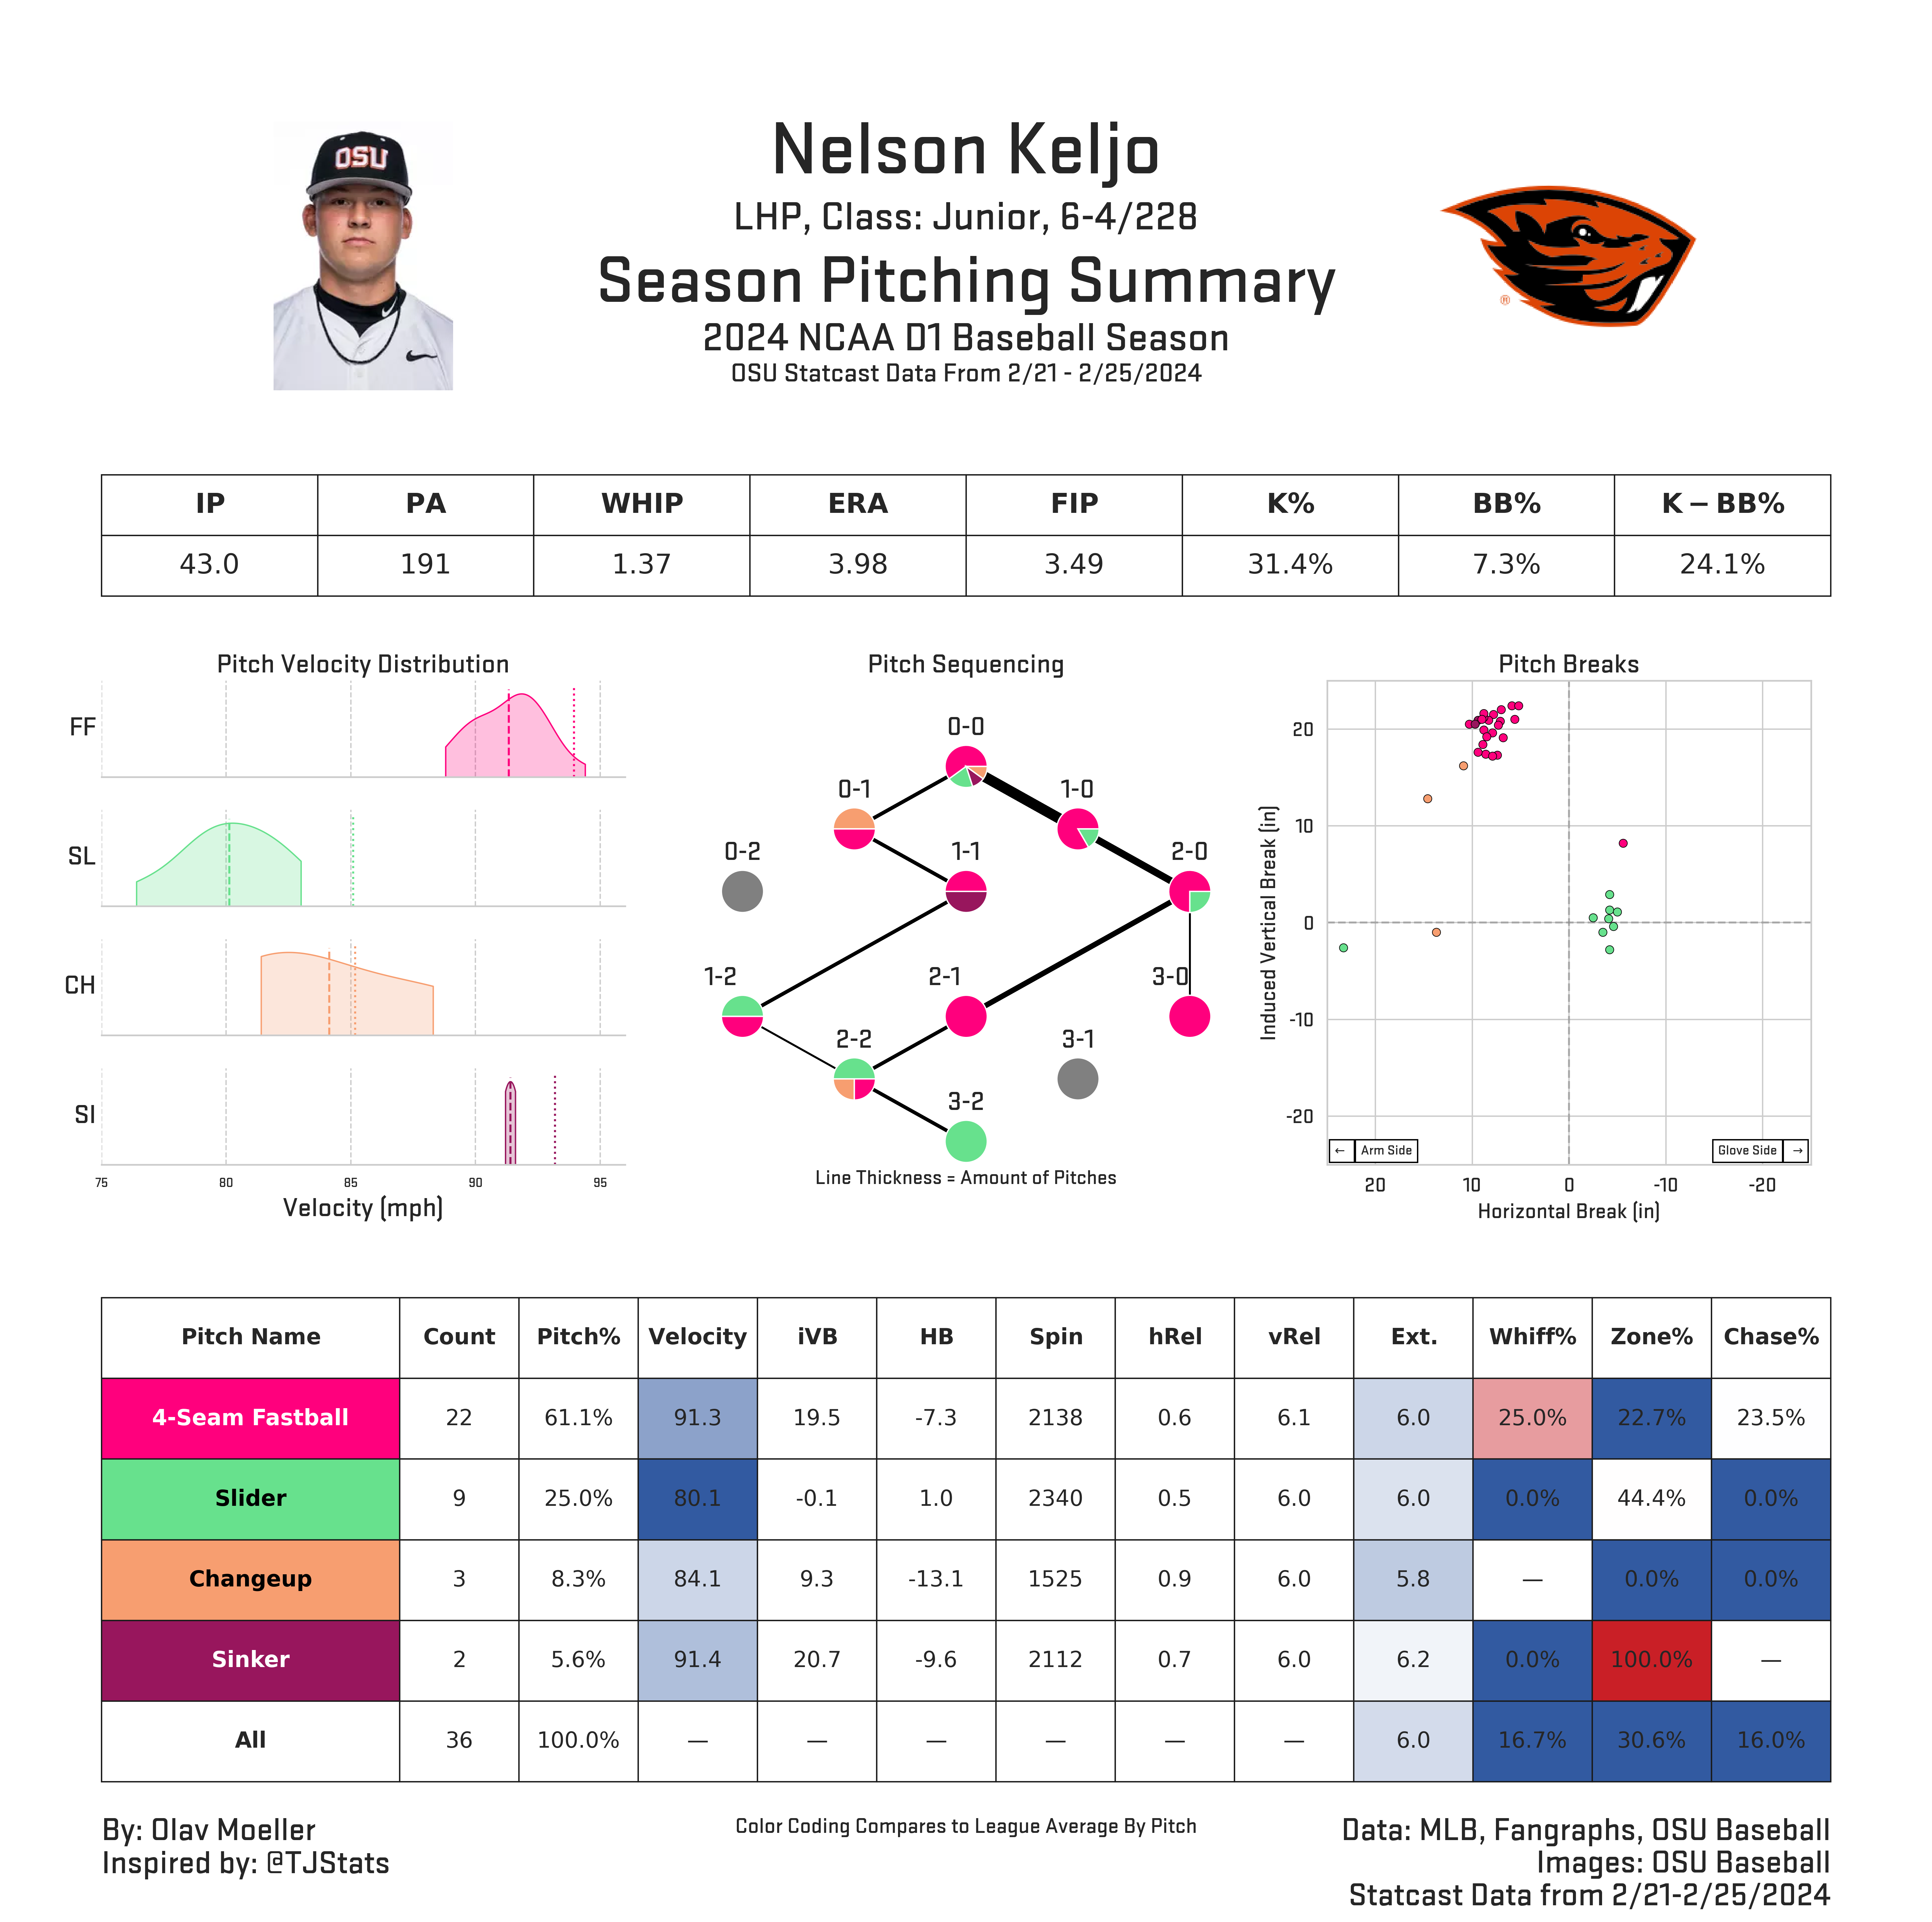

In [ ]:
pitching_dashboard('Nelson Keljo', 2024)

## Creating the pitch similarity graphic

One of the main goals for this project was to compare college level pitchers arsenals with those of MLB pitchers, and use that to assess their performance and create game plans based on MLB data. To do this comparison, I wanted to use Euclidean distance, which essentially determines how close one data point is to another, and find the Euclidean distance for every MLB pitch compared to our relevant pitcher. Then, when finding the closest MLB pitch, we can get information from that and project how good the pitch will be. This can also be done for non college pitchers, to see how good a recruit could be based on their metrics.

Euclidean distance had to be normalized, so that the distance was similar between each factor of the pitch. Otherwise differences in spin rate being 100 rpms would have a much greater effect on distance than a velocity difference of 10 mph, but logically, 10 mph is a much more different pitch than one with a 100 rpm difference.

To do this, I used z scores, comparing each pitch's attributes to the MLB mean and standard deviation within that pitch type, putting all attributes on the same scale.

In [ ]:
# Using Eric Segura as our example again, focusing on his curveball
ex_pitchername = 'Eric Segura'
ex_year = 2024
ex_pitchtype = 'CU'
ex_link = get_player_link(playername=ex_pitchername, year=ex_year)

<IPython.core.display.Javascript object>

### Data Processing

#### Z scores OSU Data

Here we find the z-scores for our OSU pitcher, and save them in a dataframe

In [ ]:
# Creating a dataframe with MLB averages in relevant metrics across all 4 years
mlbav = mlbpd.groupby(['pitch_type','pitcher_hand']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        start_speed_avg = ('start_speed','mean'),  # Average start speed
                        start_speed_std = ('start_speed','std'),  # Standard deviation of start speed
                        ivb_avg = ('ivb','mean'),  # Average vertical movement
                        ivb_std = ('ivb','std'),  # Standard deviation of vertical movement
                        hb_avg = ('hb','mean'),  # Average horizontal movement
                        hb_std = ('hb','std'),  # Standard deviation of horizontal movement
                        spin_rate_avg = ('spin_rate','mean'),  # Average spin rate
                        spin_rate_std = ('spin_rate','std'),  # Standard deviation of spin rate
                        x0_avg = ('release_side','mean'),  # Average horizontal release position
                        x0_std = ('release_side','std'),  # Standard deviation of horizontal release position
                        z0_avg = ('release_height','mean'),  # Average vertical release position
                        z0_std = ('release_height','std'),  # Standard deviation of vertical release position
                        extension_avg = ('extension','mean'),  # Average release extension
                        extension_std = ('extension','std'),  # Standard deviation of release extension
                        spin_axis_avg = ('spin_direction','mean'),  # Average spin axis
                        spin_axis_std = ('spin_direction','std'),  # Standard deviation of spin axis
                        ).reset_index()

# Creating a function that creates a dataframe with our OSU pitcher's z-scores
def osu_z_df(playername, year):
    # Defining our dataframe by selected pitcher
    df_raw = player_year_data(playername, year)

    # Grouping the dataframe, in the same way that the MLB Average is done
    df = gen_grouping(df_raw)

    # Mapping the MLB average data to our pitchers relevant pitches
    df_big = pd.merge(df, mlbav, how='left', left_on=['pitch_type','pitcher_hand'], right_on=['pitch_type','pitcher_hand'])

    # Creating a blank dataframe that will hold z scores
    osu_z = pd.DataFrame()

    # Adding baseic columns to the dataframe
    osu_z[['pitcher_name','pitcher_hand','year','pitch_type', 'pitch']] = df[['pitcher_name','pitcher_hand','year','pitch_type', 'pitch']]

    # Z scores for Velocity
    osu_z['start_speed_z'] = ((df_big['start_speed'])-(df_big['start_speed_avg']))/df_big['start_speed_std']

    # Z scores for vertical movement
    osu_z['ivb_z'] = ((df_big['ivb'])-(df_big['ivb_avg']))/df_big['ivb_std']

    # Z scores for horizontal movement
    osu_z['hb_z'] = ((df_big['hb'])-(df_big['hb_avg']))/df_big['hb_std']

    # Z scores for spin rate
    osu_z['spin_rate_z'] = ((df_big['spin_rate'])-(df_big['spin_rate_avg']))/df_big['spin_rate_std']

    # Z scores for horizontal release point
    osu_z['x0_z'] = ((df_big['x0'])-(df_big['x0_avg']))/df_big['x0_std']

    # Z scores for vertical release point
    osu_z['z0_z'] = ((df_big['z0'])-(df_big['z0_avg']))/df_big['z0_std']

    # Z scores for release extension
    osu_z['extension_z'] = ((df_big['extension'])-(df_big['extension_avg']))/df_big['extension_std']

    # Z scores for spin axis
    osu_z['spin_axis_z'] = ((df_big['spin_axis'])-(df_big['spin_axis_avg']))/df_big['spin_axis_std']

    return osu_z

osu_z_df(playername=ex_pitchername, year=ex_year)

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  3.30iteration/s]

Converting Data to Dataframe.


pitcher_name pitcher_hand  year pitch_type  pitch  start_speed_z     ivb_z  \
0  Eric Segura            R  2024         CH      7      -0.262118 -1.423635   
1  Eric Segura            R  2024         CU     11      -0.094586  1.172181   
2  Eric Segura            R  2024         FF      3      -0.660845 -0.882233   
3  Eric Segura            R  2024         SI     60      -0.412823  0.526583   

       hb_z  spin_rate_z      x0_z      z0_z  extension_z  spin_axis_z  
0 -0.880617     0.222048 -0.629645 -2.397479     0.767568     1.027181  
1 -1.327180    -0.980648 -0.861709 -2.495693     0.497133     0.503554  
2  0.296475     0.610296 -0.718468 -1.899821    -0.228245     1.852538  
3 -0.417995     1.260046 -0.637428 -1.081472    -0.042369     0.869984

#### Z scores MLB Data

Here we find the z scores for each MLB pitch, and save them in a dataframe. These don't change depending on anything, so no functions are necessary.

In [ ]:
# Similarly mapping the MLB average data to all pitchers data
mlbpd_big = pd.merge(mlbpdall, mlbav, how='left', left_on=['pitch_type','pitcher_hand'], right_on=['pitch_type','pitcher_hand'])

# Creating a blank dataframe that will hold z scores
mlbpd_z = pd.DataFrame()

# Adding basic columns to the dataframe
mlbpd_z[['pitcher_name','pitcher_hand','year','pitch_type', 'pitch']] = mlbpdall[['pitcher_name','pitcher_hand','year','pitch_type', 'pitch']]

# Z scores for Velocity
mlbpd_z['start_speed_z'] = ((mlbpd_big['start_speed'])-(mlbpd_big['start_speed_avg']))/mlbpd_big['start_speed_std']

# Z scores for vertical movement
mlbpd_z['ivb_z'] = ((mlbpd_big['ivb'])-(mlbpd_big['ivb_avg']))/mlbpd_big['ivb_std']

# Z scores for horizontal movement
mlbpd_z['hb_z'] = ((mlbpd_big['hb'])-(mlbpd_big['hb_avg']))/mlbpd_big['hb_std']

# Z scores for spin rate
mlbpd_z['spin_rate_z'] = ((mlbpd_big['spin_rate'])-(mlbpd_big['spin_rate_avg']))/mlbpd_big['spin_rate_std']

# Z scores for horizontal release point
mlbpd_z['x0_z'] = ((mlbpd_big['x0'])-(mlbpd_big['x0_avg']))/mlbpd_big['x0_std']

# Z scores for vertical release point
mlbpd_z['z0_z'] = ((mlbpd_big['z0'])-(mlbpd_big['z0_avg']))/mlbpd_big['z0_std']

# Z scores for release extension
mlbpd_z['extension_z'] = ((mlbpd_big['extension'])-(mlbpd_big['extension_avg']))/mlbpd_big['extension_std']

# Z scores for spin axis
mlbpd_z['spin_axis_z'] = ((mlbpd_big['spin_axis'])-(mlbpd_big['spin_axis_avg']))/mlbpd_big['spin_axis_std']

# Changing the dataframe to have just pitches with at least a 20 sample size
mlbpd_z = mlbpd_z[mlbpd_z['pitch'] >= 20]

mlbpd_z.head()


pitcher_name pitcher_hand  year pitch_type  pitch  start_speed_z     ivb_z  \
0   A.J. Alexy            R  2021         CH     77      -0.020533  1.271415   
1   A.J. Alexy            R  2021         CU     34      -0.838671 -1.398758   
2   A.J. Alexy            R  2021         FF    231      -0.434836  1.093668   
3   A.J. Alexy            R  2021         SL     82      -1.363805 -0.782520   
5   A.J. Alexy            R  2022         CU     20      -0.182685 -1.279799   

       hb_z  spin_rate_z      x0_z      z0_z  extension_z  spin_axis_z  
0 -1.758633    -0.968036  0.813129  0.316682     0.613304    -1.138547  
1 -0.022035    -0.315615  0.966731  0.403619     0.503756    -0.646542  
2 -0.810241    -0.440562  0.863766  0.262185     0.602280    -0.978134  
3 -0.473037    -0.205638  0.890216  0.257598     0.785235    -0.699569  
5  0.438802    -0.315287  1.136852  0.498789     0.089457    -0.692085

#### Mapping OSU Data to MLB Data to find Euclidian distance

Now that we have a way to filter our OSU pitcher's data, and mlb's data is filtered, we just have to compare the two to find a Euclidean distance, determining the most similar pitchers.

In [ ]:
def pitch_similarity(playername, year):
    # Defining our dataframe by selected pitcher
    osu_z = osu_z_df(playername, year)

    # Making a smaller OSU dataframe to be compared
    osu_z_comp = osu_z.copy().drop(columns=['pitcher_name','year','pitch'])

    # Merging the z scores for our selected OSU pitcher with the dataframe of all MLB pitchers
    mlbpd_comparison = pd.merge(mlbpd_z, osu_z_comp, how='left', left_on=['pitch_type','pitcher_hand'], right_on=['pitch_type','pitcher_hand']).set_index(mlbpd_z.index)

    # Using numpy to calculate the Euclidean distance between our OSU pitcher's metrics and the MLB pitchers metrics
    mlbpd_comparison['euclidean'] = np.linalg.norm(mlbpd_comparison[['start_speed_z_x','ivb_z_x','hb_z_x','spin_rate_z_x','x0_z_x','z0_z_x','extension_z_x','spin_axis_z_x']].values - mlbpd_comparison[['start_speed_z_y','ivb_z_y','hb_z_y','spin_rate_z_y','x0_z_y','z0_z_y','extension_z_y','spin_axis_z_y']].values,axis=1)

    # Creating a dataframe containing the similar pitchers, pitch types, and year, to be sorted by distance
    mlbpd_similar_full = mlbpd_comparison[['pitcher_name','pitch_type','year','euclidean']]

    # Sorting our dataframe by which pitches are most similar, for each pitch type
    similar_list = []
    for x in osu_z['pitch_type']:
        similar_list.append(mlbpd_similar_full.loc[mlbpd_similar_full['pitch_type'] == x].sort_values(by='euclidean').head(3))
    output = pd.concat(similar_list)

    return output

pitch_similarity(playername=ex_pitchername, year=ex_year)

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.61iteration/s]


Converting Data to Dataframe.


pitcher_name pitch_type  year  euclidean
14797     Seth Martinez         CH  2024   1.394415
14788     Seth Martinez         CH  2022   1.545783
16597     Victor Vodnik         CH  2023   1.574240
2444       Bryse Wilson         CU  2022   1.184996
2438       Bryse Wilson         CU  2021   1.202220
16256       Tyler Beede         CU  2024   1.516070
13165  Peter Strzelecki         FF  2023   0.939590
13170  Peter Strzelecki         FF  2024   1.097953
12295     Mychal Givens         FF  2022   1.160957
5351        Edwin Uceta         SI  2024   1.544973
5347        Edwin Uceta         SI  2023   1.561608
13772     Robert Dugger         SI  2020   1.566538

### Parts of the chart

#### Short Title/Bio

We can reuse the headshot and OSU logo functions from earlier, so there is no need to repeat them.

The top of the chart will look similar to the general one, but this time we will specify pitch type.

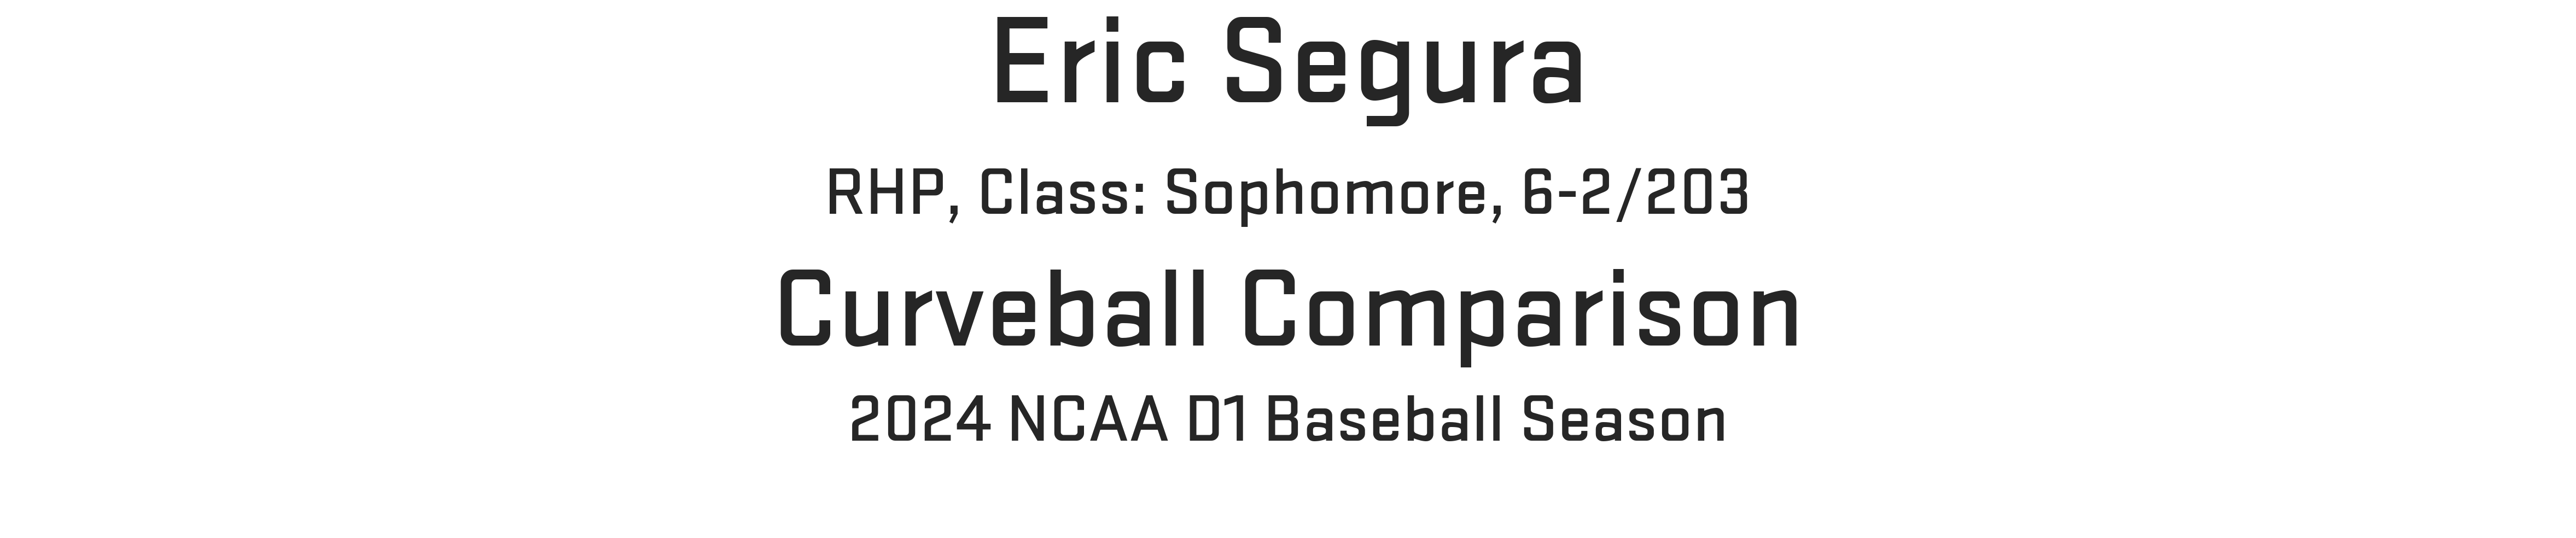

In [ ]:
def comp_bio(playername, year, pitchtype, link, ax):
    # Using the players link to create a soup object
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Determining pitcher handedness
    if soup.find("dt", string="Position: ").find_parent().get_text().split(': ')[1].split('-')[0] == "Right":
      pitcher_hand = 'RHP'
    else:
      pitcher_hand = 'LHP'

    # Calling pitcher class
    pitcher_class = soup.find("dt", string="Class: ").find_parent().get_text()

    # Calling height/weight
    height = soup.find("dt", string="Height: ").find_parent().get_text().split(': ')[1]
    weight = soup.find("dt", string="Weight: ").find_parent().get_text().split(': ')[1]

    # Display the graphic
    ax.text(0.5, 1, f'{playername}', va='top', ha='center', fontsize=56, font=stratum)
    ax.text(0.5, 0.70, f'{pitcher_hand}, {pitcher_class}, {height}/{weight}', va='top', ha='center', fontsize=30, font=stratum)
    ax.text(0.5, 0.50, f'{dict_pitch[pitchtype]} Comparison', va='top', ha='center', fontsize=50, font=stratum)
    ax.text(0.5, 0.25, f'{year} NCAA D1 Baseball Season', va='top', ha='center', fontsize=30, fontstyle='italic', font=stratum)
    ax.axis('off')


comp_bio(ex_pitchername, ex_year, ex_pitchtype, ex_link, ax=plt.subplots(figsize=(20, 4))[1])

#### Pitch Metrics Data Table

Similar to our statcast table at the bottom of the general summary graphic, we will include the relevant metrics we used for comparison, so the viewer can see the specific similarities and differences in each aspect of a pitch.

This formula will create a dataframe of the values we want in the table

In [ ]:
def metric_table_df(playername, year, pitchtype):
    # Creating the line of the table for our OSU pitcher
    df_raw = player_year_data(playername, year)
    df = df_raw.groupby(['pitcher_name','pitcher_hand','year','pitch_type']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        start_speed = ('start_speed','mean'),  # Average start speed
                        ivb = ('ivb','mean'),  # Average vertical movement
                        hb = ('hb','mean'),  # Average horizontal movement
                        spin_rate = ('spin_rate','mean'),  # Average spin rate
                        spin_axis = ('spin_direction','mean'),  # Average spin axis
                        x0 = ('release_side','mean'),  # Average horizontal release position
                        z0 = ('release_height','mean'),  # Average vertical release position
                        extension = ('extension','mean'),  # Average release extension
                        ).reset_index()
    df_relevant = df.loc[df['pitch_type'] == pitchtype]
    df_relevant.assign(euclidean = 0)

    # Finding the three most similar pitchers
    similar_df = pitch_similarity(playername=playername, year=year)
    similar_df_pitchtype = similar_df.loc[similar_df['pitch_type'] == pitchtype]

    # Finding each of these pitchers metrics
    index_list = similar_df_pitchtype.index.tolist()
    metrics = mlbpdall.loc[index_list].drop(['swing', 'whiff', 'in_zone', 'out_zone', 'chase'], axis=1)
    metrics['euclidean'] = similar_df_pitchtype['euclidean']

    # Joining the two dataframes for the chart
    df_table = pd.concat([df_relevant, metrics], axis=0).reset_index(drop=True).drop(columns=['pitcher_hand','pitch_type'])

    return df_table


metric_table_df(ex_pitchername, ex_year, ex_pitchtype)

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  2.72iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 11.89iteration/s]


Converting Data to Dataframe.


pitcher_name  year  pitch  start_speed       ivb         hb    spin_rate  \
0   Eric Segura  2024     11    79.000000 -3.218182 -16.100000  2253.818182   
1  Bryse Wilson  2022    248    77.464919 -3.140726 -16.055242  2298.294355   
2  Bryse Wilson  2021    131    77.012977 -3.269466 -16.669466  2321.908397   
3   Tyler Beede  2024     62    77.533871 -5.764516 -14.622581  2105.790323   

   spin_axis        x0        z0  extension  euclidean  
0  60.363636 -2.265912  4.839465   6.525305        NaN  
1  55.596774 -1.983747  5.341710   6.540424   1.313439  
2  54.083969 -2.517648  5.323348   6.589449   1.347477  
3  48.193548 -1.918872  5.312003   6.278121   1.611680

Now we will convert the dataframe into an actual table to be shown on our graphic

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 15.07iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 15.95iteration/s]


Converting Data to Dataframe.


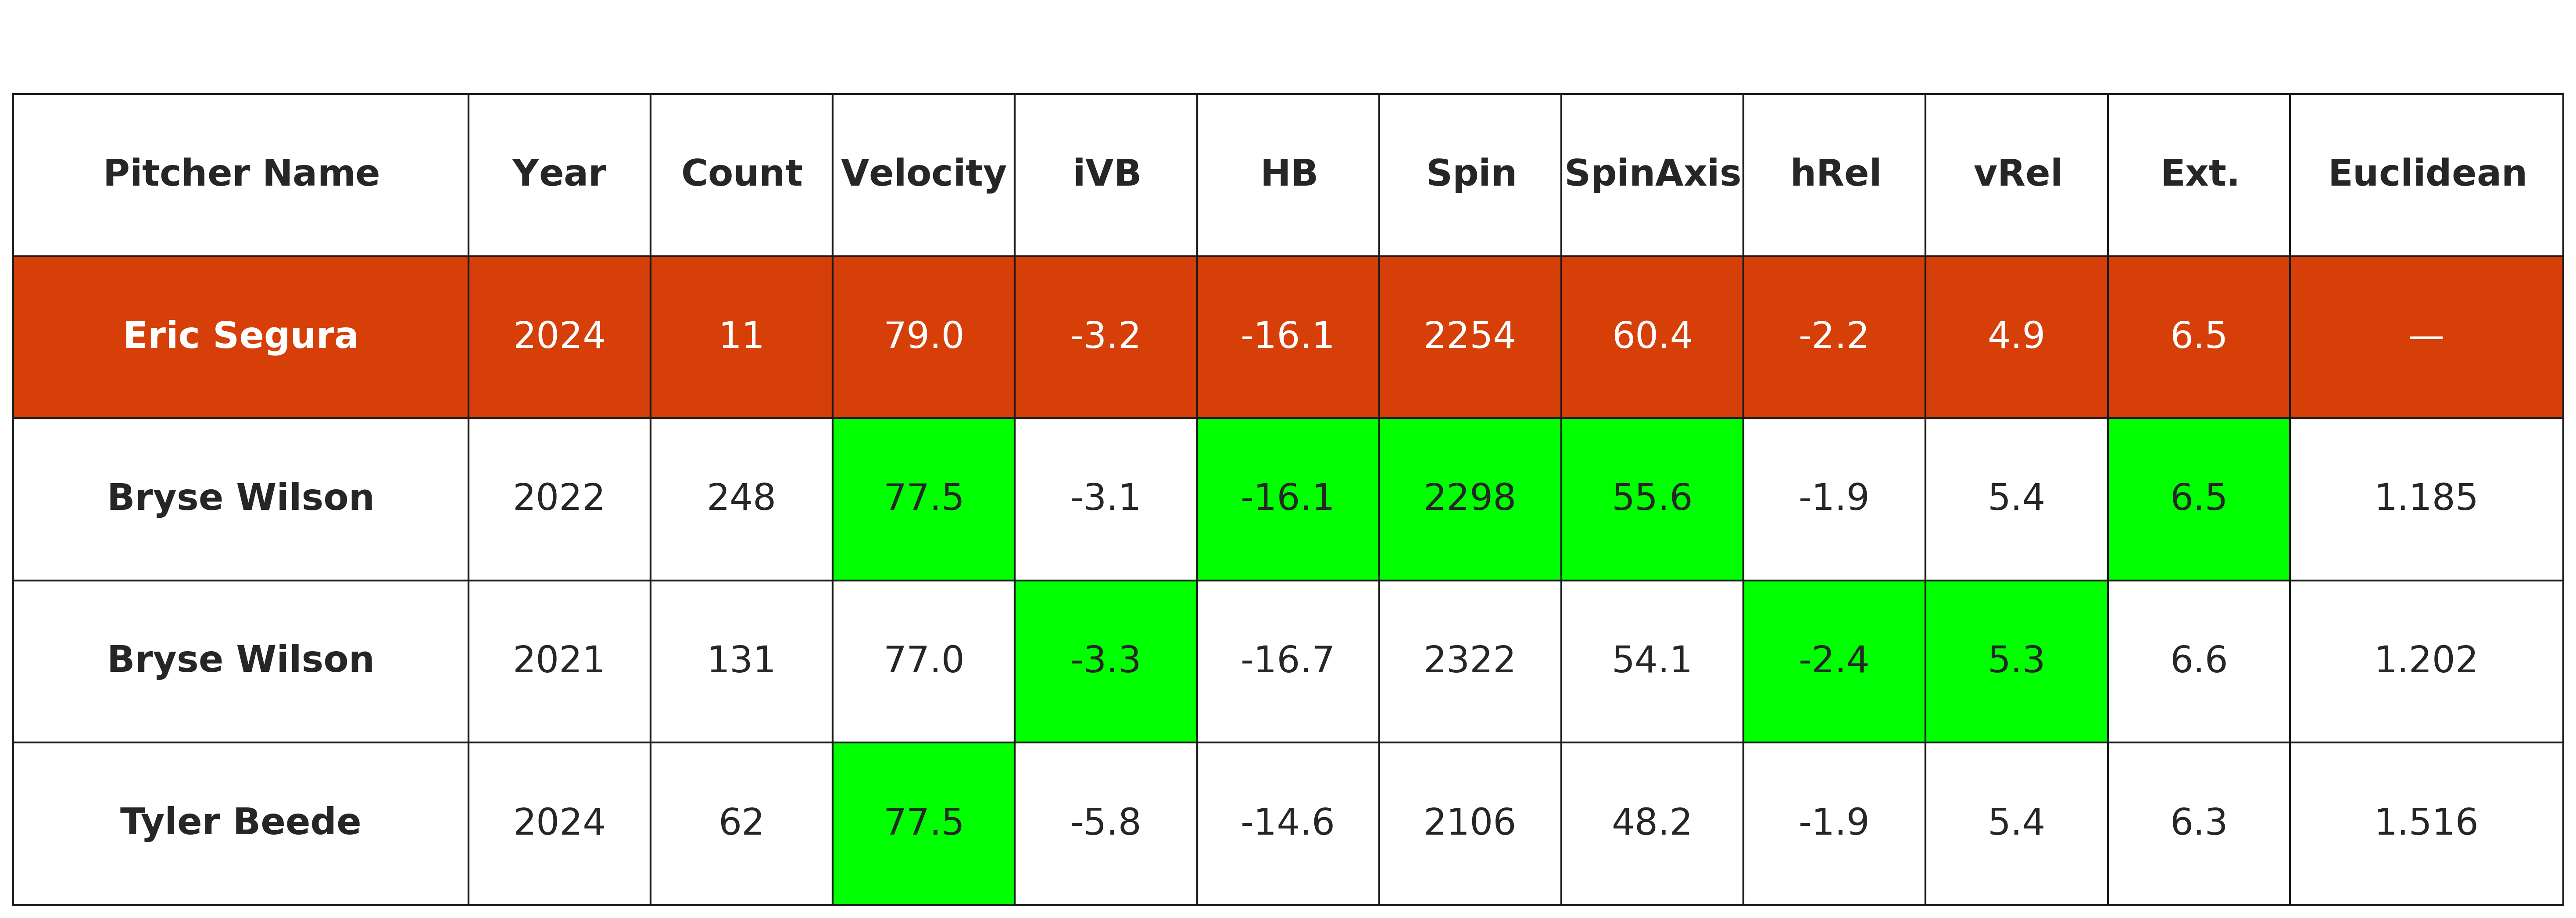

In [ ]:
# Assigning the columns we wish to show
comp_table_columns = [ 'pitcher_name',
            'year',
            'pitch',
            'start_speed',
            'ivb',
            'hb',
            'spin_rate',
            'spin_axis',
            'x0',
            'z0',
            'extension',
            'euclidean'
            ]

def metric_table(playername, year, pitchtype, ax, fontsize:int=20):
    # Creating our dataframe
    df = metric_table_df(playername, year, pitchtype)
    df_plot = plot_pitch_format(df, comp_table_columns)

    # Create a table plot with the DataFrame values and specified column labels
    table_plot = ax.table(cellText=df_plot.values, colLabels=comp_table_columns, cellLoc='center',
                        bbox=[0, -0.1, 1, 1],
                        colWidths=[2.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.5, 1, 1, 1])

    # Disable automatic font size adjustment and set the font size
    table_plot.auto_set_font_size(False)
    table_plot.set_fontsize(fontsize)

    # Scale the table plot
    table_plot.scale(1, 0.5)

    # Correctly format the new column names using LaTeX formatting
    new_column_names = ['$\\bf{Pitcher\\ Name}$'] + ['$\\bf{Year}$'] + [pitch_stats_dict[x]['table_header'] if x in pitch_stats_dict else '---' for x in comp_table_columns[2:]]

    # Update the table headers with the new column names
    for i, col_name in enumerate(new_column_names):
        table_plot.get_celld()[(0, i)].get_text().set_text(col_name)

    # Bold the first column in the table
    for i in range(len(df_plot)):
        table_plot.get_celld()[(i+1, 0)].get_text().set_fontweight('bold')

    # Set the color for our OSU pitcher's entry
    for i in range(0,12):
        table_plot.get_celld()[(1, i)].set_text_props(color='#FFFFFF')
        table_plot.get_celld()[(1, i)].set_facecolor('#D73F09')

    # Highlight in green the most similar values within each category
    for j in range(3, 11):
        diff_list = []
        for i in range(2, 5):
            val = float(table_plot.get_celld()[(i, j)].get_text().get_text())
            baseval = float(table_plot.get_celld()[(1, j)].get_text().get_text())
            diff = abs(val - baseval)
            diff_list.append(diff)
        min_diff = min(diff_list)
        for i in range(2, 5):
            if diff_list[i-2] == min_diff:
                table_plot.get_celld()[(i, j)].set_facecolor('#00FF00')


    # Remove the axis
    ax.axis('off')

metric_table(ex_pitchername, ex_year, ex_pitchtype, ax=plt.subplots(figsize=(25, 8))[1])

#### MLB Comparison Headshot

Now we will have functions to call our similar MLB pitchers, and display their headshots

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 10.99iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00,  5.81iteration/s]


Converting Data to Dataframe.
Gathering player lookup table. This may take a moment.


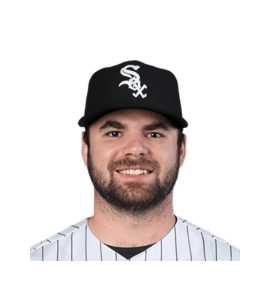

In [ ]:
def get_mlb_headshot(playername, ax):
    # Taking our pitcher's name and finding their MLB ID
    last = playername.split(maxsplit=1)[1]
    first = playername.split(maxsplit=1)[0]
    pitcher_id = pyb.playerid_lookup(last,first)['key_mlbam'].loc[0]

    # Construct the URL for the player's headshot image
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
          f'upload/d_people:generic:headshot:67:current.png'\
          f'/w_640,q_auto:best/v1/people/{pitcher_id}/headshot/silo/current.png'

    # Send a GET request to the URL
    response = requests.get(url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))


    # Display the image on the axis
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')

# Setting an example pitcher, the most similar pitcher to Eric Segura's Curveball (Bryse Wilson), and finding his headshot
pitcher_comp_1 = pitch_similarity(ex_pitchername, ex_year).loc[pitch_similarity(ex_pitchername, ex_year)['pitch_type'] == ex_pitchtype].reset_index(drop=True).loc[0,'pitcher_name']
get_mlb_headshot(playername=pitcher_comp_1, ax=plt.subplots(figsize=(1, 1))[1])

#### MLB Pitchers Short Bio

Now we want to have a bio for each pitcher, to give more information about them. We will scrape Baseball Reference for this data.

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  2.75iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.96iteration/s]


Converting Data to Dataframe.


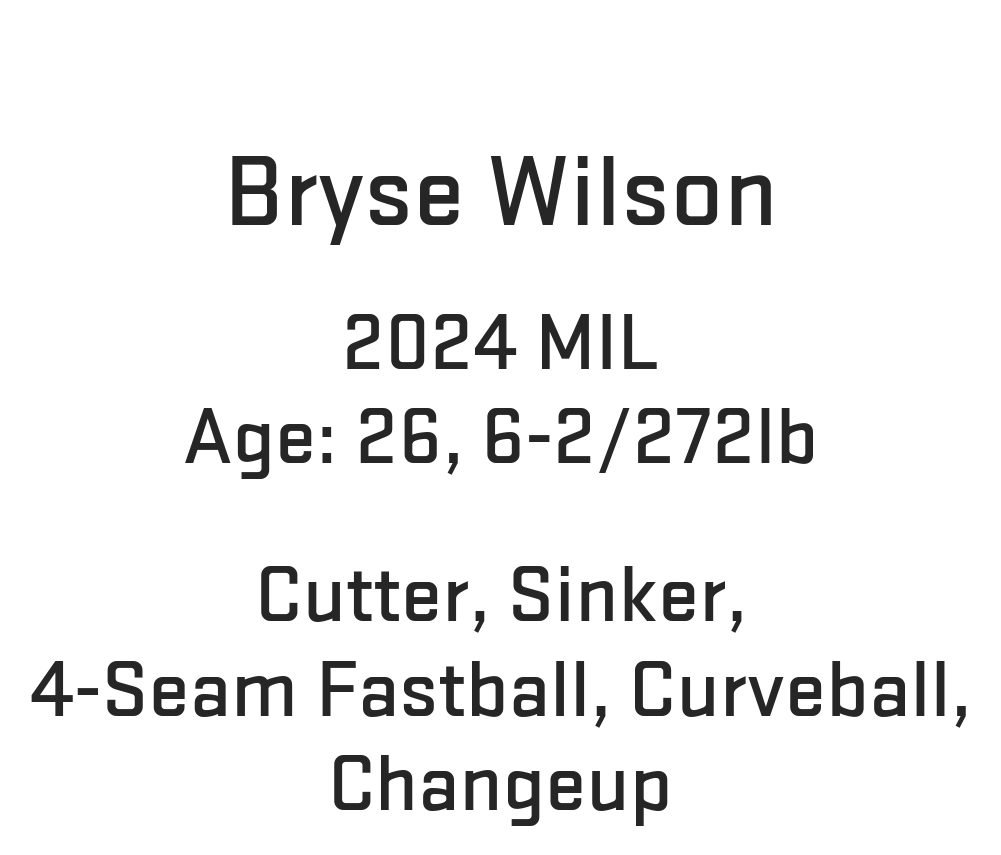

In [ ]:
# Setting the year that our MLB pitcher had similar pitch shapes, as an example
pitcher_comp_1_year = pitch_similarity(ex_pitchername, ex_year).loc[pitch_similarity(ex_pitchername, ex_year)['pitch_type'] == 'SI'].reset_index(drop=True).loc[0,'year']

def mlb_bio(playername, year, ax):
    # Getting the player's bbref ID so we can look them up
    last = playername.split(maxsplit=1)[1]
    first = playername.split(maxsplit=1)[0]
    last_initial = last[0].lower()
    pitcher_id = pyb.playerid_lookup(last,first)['key_bbref'].loc[0]

    # Getting their baseball reference page as a soup object
    link = f'https://www.baseball-reference.com/players/{last_initial}/{pitcher_id}.shtml'
    response = requests.get(link)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Finding data on the player's season of interest
    data = soup.find("tr", id=re.compile(f"{year}"))
    age = data.find(attrs={"data-stat": "age"}).text
    team = data.find(attrs={"data-stat": "team_name_abbr"}).text
    arsenal = mlbpdall.loc[(mlbpdall['pitcher_name'] == playername) & (mlbpdall['year'] == year) & (mlbpdall['pitch'] >= 20)].sort_values(by='pitch', ascending=False)['pitch_type'].map(dict_pitch).to_list()
    ip = data.find(attrs={"data-stat": "p_ip"}).text
    era = data.find(attrs={"data-stat": "p_earned_run_avg"}).text
    bwar = data.find(attrs={"data-stat": "p_war"}).text

    # Finding general info on the player
    height = soup.find_all("span")[9:10][0].contents[0]
    weight = soup.find_all("span")[10:11][0].contents[0]

    # Display the graphic, depending on how many pitches, the graphic will be different
    if len(arsenal) <= 2:
        arsenal_words = ", ".join(arsenal)
        ax.text(0.5, 0.90, f'{playername}', va='top', ha='center', fontsize=25, font=stratum)
        ax.text(0.5, 0.65, f'{year} {team}', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.30, f'Age: {age}, {height}/{weight}', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.00, f'{arsenal_words}', va='top', ha='center', fontsize=20, font=stratum)
    elif len(arsenal) <= 4:
        arsenal_words1 = ", ".join(arsenal[0:2])
        arsenal_words2 = ", ".join(arsenal[2:4])
        ax.text(0.5, 0.90, f'{playername}', va='top', ha='center', fontsize=25, font=stratum)
        ax.text(0.5, 0.65, f'{year} {team}', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.50, f'Age: {age}, {height}/{weight}', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.20, f'{arsenal_words1},', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.05, f'{arsenal_words2}', va='top', ha='center', fontsize=20, font=stratum)
    elif len(arsenal) <= 6:
        arsenal_words1 = ", ".join(arsenal[0:2])
        arsenal_words2 = ", ".join(arsenal[2:4])
        arsenal_words3 = ", ".join(arsenal[4:6])
        ax.text(0.5, 0.90, f'{playername}', va='top', ha='center', fontsize=25, font=stratum)
        ax.text(0.5, 0.65, f'{year} {team}', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.50, f'Age: {age}, {height}/{weight}', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.25, f'{arsenal_words1},', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.10, f'{arsenal_words2},', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, -0.05, f'{arsenal_words3}', va='top', ha='center', fontsize=20, font=stratum)
    else:
        arsenal_words1 = ", ".join(arsenal[0:2])
        arsenal_words2 = ", ".join(arsenal[2:4])
        arsenal_words3 = ", ".join(arsenal[4:6])
        arsenal_words4 = ", ".join(arsenal[6:])
        ax.text(0.5, 0.90, f'{playername}', va='top', ha='center', fontsize=25, font=stratum)
        ax.text(0.5, 0.65, f'{year} {team}', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.50, f'Age: {age}, {height}/{weight}', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.35, f'{arsenal_words1},', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.20, f'{arsenal_words2},', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, 0.05, f'{arsenal_words3},', va='top', ha='center', fontsize=20, font=stratum)
        ax.text(0.5, -0.10, f'{arsenal_words4}', va='top', ha='center', fontsize=20, font=stratum)
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)
mlb_bio(pitcher_comp_1, pitcher_comp_1_year, ax=plt.subplots(figsize=(3,3))[1])


#### MLB Pitchers' Results Chart

Now, as a method of showing how good a pitch may be by its pure metrics, or which pitcher we may look to as a guide for arsenals and usage, we will show each pitchers results, both season-long and with the specific pitch of interest. For the first time we will be using pyBaseball's datascraping, to find a few more complex statistics regarding the MLB pitchers' performances

In [ ]:
# Adding a function to process the data that is returned from a pybaseball request
def df_processing_pyb(df_pyb: pd.DataFrame):
    df = df_pyb.copy()
    # Define the codes for different types of swings and whiffs
    swing_code = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip',
                'swinging_strike_blocked','missed_bunt','bunt_foul_tip']
    whiff_code = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']

    # Create new columns in the DataFrame to indicate swing, whiff, in-zone, out-zone, and chase
    df['swing'] = (df['description'].isin(swing_code))
    df['whiff'] = (df['description'].isin(whiff_code))
    df['in_zone'] = (df['zone'] < 10)
    df['out_zone'] = (df['zone'] > 10)
    df['chase'] = (df.in_zone==False) & (df.swing == 1)

    # Convert the pitch movement to inches, not feet
    df['pfx_z'] = df['pfx_z'] * 12
    df['pfx_x'] = df['pfx_x'] * 12
    return df

# Listing the columns we want to have in our final table
comp_results_table_columns = ['player_name', 'year', 'IP', 'ERA', 'bWAR', 'delta_run_exp_per_100', 'pitch_usage', 'pitch_usage_r', 'pitch_usage_l', 'whiff_rate', 'in_zone_rate', 'chase_rate', 'xwoba']


Now we'll do some data manipulation and make a function that returns our goal table as a dataframe.

In [ ]:
def result_table_df(playername, year, pitchtype):
    # Finding the 3 relevant MLB pitchers
    similar_df = pitch_similarity(playername=playername, year=year)
    similar_df_pitchtype = similar_df.loc[similar_df['pitch_type'] == pitchtype]

    # Creating a list that will hold each row of our dataframe
    df_list = []

    # Creating a dataframe row for each pitcher, using pybaseball
    for i, j in zip(similar_df_pitchtype['pitcher_name'], similar_df_pitchtype['year']):

        # Finding the pitcher id for the pitcher
        pitcher_id = pyb.playerid_lookup(i.split(maxsplit=1)[1],i.split(maxsplit=1)[0])['key_mlbam'].loc[0]

        # Using pybaseball to get their seasonlong data from the relevant season at the pitch level
        df_pyb_full = pyb.statcast_pitcher(f'{j}-01-01',f'{j}-12-31', pitcher_id)

        # Filtering the data to be regular season only and our selected pitch
        df_pyb_reg = df_pyb_full[(df_pyb_full['game_type'] == 'R')]

        # Processing the data to note whiffs and other interesting stats
        df = df_processing_pyb(df_pyb_reg)

        # Group the DataFrame by pitch type and to find handedness usage
        df_group = df.groupby(['player_name', 'pitch_type', 'stand']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                    ).reset_index()

        # Add a variable for usage vs lefties and righties
        usage_r = df_group[(df_group['pitch_type'] == pitchtype) & (df_group['stand'] == 'R')]['pitch'].reset_index(drop=True) / sum((df_group[df_group['stand'] == 'R']['pitch']))
        usage_l = df_group[(df_group['pitch_type'] == pitchtype) & (df_group['stand'] == 'L')]['pitch'].reset_index(drop=True) / sum((df_group[df_group['stand'] == 'L']['pitch']))
        usage_r_list = usage_r.to_list() or [0]
        usage_l_list = usage_l.to_list() or [0]

        # Grouping the dataframe the way it will appear in the final dataframe
        df_group_new = df.groupby(['player_name', 'pitch_type']).agg(
                        pitch = ('pitch_type','count'),  # Count of pitches
                        delta_run_exp = ('delta_run_exp','sum'),  # Total change in run expectancy
                        swing = ('swing','sum'),  # Total swings
                        whiff = ('whiff','sum'),  # Total whiffs
                        in_zone = ('in_zone','sum'),  # Total in-zone pitches
                        out_zone = ('out_zone','sum'),  # Total out-of-zone pitches
                        chase = ('chase','sum'),  # Total chases
                        xwoba = ('estimated_woba_using_speedangle','mean'),  # Average expected wOBA
        ).reset_index()

        # Calculate pitch usage as a percentage of total pitches
        df_group_new['pitch_usage'] = df_group_new['pitch'] / df_group_new['pitch'].sum()

        # Calculate whiff rate as the ratio of whiffs to swings
        df_group_new['whiff_rate'] = df_group_new['whiff'] / df_group_new['swing']

        # Calculate in-zone rate as the ratio of in-zone pitches to total pitches
        df_group_new['in_zone_rate'] = df_group_new['in_zone'] / df_group_new['pitch']

        # Calculate chase rate as the ratio of chases to out-of-zone pitches
        df_group_new['chase_rate'] = df_group_new['chase'] / df_group_new['out_zone']

        # Calculate delta run expectancy per 100 pitches
        df_group_new['delta_run_exp_per_100'] = -df_group_new['delta_run_exp'] / df_group_new['pitch'] * 100

        # Filter the dataframe by selected pitch type
        df_group_new = df_group_new[df_group_new['pitch_type'] == pitchtype].reset_index(drop=True)

        # Add columns for the usage by handedness
        df_group_new = df_group_new.assign(pitch_usage_r = usage_r_list)
        df_group_new = df_group_new.assign(pitch_usage_l = usage_l_list)

        # Adding a column for year
        df_group_new['year'] = j

        # Adding columns for season stats, which won't be from the pybaseball/statcast data

        # Getting the player's bbref ID so we can look them up
        last = i.split(maxsplit=1)[1]
        first = i.split(maxsplit=1)[0]
        last_initial = last[0].lower()
        pitcher_id = pyb.playerid_lookup(last,first)['key_bbref'].loc[0]

        # Getting their baseball reference page as a soup object
        link = f'https://www.baseball-reference.com/players/{last_initial}/{pitcher_id}.shtml'
        response = requests.get(link)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Finding data on the player's season of interest
        data = soup.find("tr", id=re.compile(f"{j}"))
        ip = data.find(attrs={"data-stat": "p_ip"}).text
        era = data.find(attrs={"data-stat": "p_earned_run_avg"}).text
        bwar = data.find(attrs={"data-stat": "p_war"}).text

        # Adding columns for the stats we are interested in
        df_group_new['IP'] = float(ip)
        df_group_new['ERA'] = float(era)
        df_group_new['bWAR'] = float(bwar)

        # Changing the playername column to be First Last like it is elsewhere
        df_group_new['player_name'] = df_group_new['player_name'].str.split(', ').str[::-1].str.join(' ')

        # Reordering the dataframe the way we want it to be in the end
        cols = ['player_name', 'year', 'IP', 'ERA', 'bWAR', 'delta_run_exp_per_100', 'pitch_usage', 'pitch_usage_r', 'pitch_usage_l', 'whiff_rate', 'in_zone_rate', 'chase_rate', 'xwoba']
        df_group_final = df_group_new[cols]

        # Adding each row to the list
        df_list.append(df_group_final)

        df_final = pd.concat(df_list).reset_index(drop=True)

    return df_final

result_table_df(ex_pitchername, ex_year, ex_pitchtype)

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00,  9.84iteration/s]


Converting Data to Dataframe.
Gathering Player Data
Gathering Player Data
Gathering Player Data


player_name  year     IP   ERA  bWAR  delta_run_exp_per_100  pitch_usage  \
0  Bryse Wilson  2022  115.2  5.52  -1.1              -1.355242     0.135890   
1  Bryse Wilson  2021   74.0  5.35   0.2              -0.113636     0.115993   
2   Tyler Beede  2024   14.0  8.36  -0.7              -0.119355     0.233962   

   pitch_usage_r  pitch_usage_l  whiff_rate  in_zone_rate  chase_rate  \
0       0.134409        0.13743    0.201835      0.483871    0.289062   
1       0.149362        0.08489    0.259259      0.416667    0.298701   
2       0.264706        0.20155    0.360000      0.419355    0.305556   

      xwoba  
0  0.341056  
1  0.265588  
2  0.313888

We also want to color code some of these values, indicating if they are better or worse than mlb league average, to show whether a pitch is doing well or in a good pitcher's arsenal.

In [ ]:
# Importing an MLB Average dataframe with values depending on pitch type (thank you again to TJStats)
df_statcast_group = pd.read_csv('https://github.com/tnestico/pitching_summary/blob/main/statcast_2024_grouped.csv?raw=true')

# Creating a dict for average season ERA using baseball references data
ERA_avg = {2024: 4.07,
           2023: 4.33,
           2022: 3.96,
           2021: 4.26,
           2020: 4.44}

In [ ]:
# Define color maps
cmap_sum = mcolors.LinearSegmentedColormap.from_list("", ['#325aa1','#FFFFFF','#c91f26'])
cmap_sum_r = mcolors.LinearSegmentedColormap.from_list("", ['#c91f26','#FFFFFF','#325aa1'])

# List of statistics to color
color_stats = ['ERA', 'bWAR', 'delta_run_exp_per_100', 'pitch_usage', 'pitch_usage_r', 'pitch_usage_l', 'whiff_rate', 'in_zone_rate', 'chase_rate', 'xwoba']

### get colors ###
def get_color(value, normalize, cmap_sum):
    color = cmap_sum(normalize(value))
    return mcolors.to_hex(color)

def get_cell_colors_comp(df_group: pd.DataFrame,
                     df_statcast_group: pd.DataFrame,
                     color_stats: list,
                     cmap_sum: mcolors.LinearSegmentedColormap,
                     cmap_sum_r: mcolors.LinearSegmentedColormap,
                     pitchtype):
    color_list_df = []
    for i in df_group.index.to_list():
        color_list_df_inner = []
        select_df = df_statcast_group[df_statcast_group['pitch_type'] == pitchtype]
        df_group_select = df_group.loc[[i]]
        year = df_group_select['year'].values[0]

        for tb in comp_results_table_columns:

            if tb in color_stats and type(df_group_select[tb].values[0]) == np.float64:
                if np.isnan(df_group_select[tb].values[0]):
                    color_list_df_inner.append('#ffffff')
                elif tb == 'bWAR':
                    normalize = mcolors.Normalize(vmin=-1, vmax=3)
                    color_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))
                elif tb == 'delta_run_exp_per_100':
                    normalize = mcolors.Normalize(vmin=-1.5, vmax=1.5)
                    color_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))
                elif tb == 'xwoba':
                    normalize = mcolors.Normalize(vmin=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 0.7,
                                                  vmax=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 1.3)
                    color_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum_r))
                elif tb == 'ERA':
                    normalize = mcolors.Normalize(vmin=ERA_avg[year] * 0.7,
                                                  vmax=ERA_avg[year] * 1.3)
                    color_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum_r))
                elif 'pitch_usage' in tb:
                    normalize = mcolors.Normalize(vmin=(pd.to_numeric(select_df['pitch_usage'], errors='coerce')).mean() * 0.7,
                                                  vmax=(pd.to_numeric(select_df['pitch_usage'], errors='coerce')).mean() * 1.3)
                    color_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))

                else:
                    normalize = mcolors.Normalize(vmin=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 0.7,
                                                  vmax=(pd.to_numeric(select_df[tb], errors='coerce')).mean() * 1.3)
                    color_list_df_inner.append(get_color((pd.to_numeric(df_group_select[tb], errors='coerce')).mean(), normalize, cmap_sum))
            else:
                color_list_df_inner.append('#ffffff')
        color_list_df.append(color_list_df_inner)
    return color_list_df

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  3.44iteration/s]


Converting Data to Dataframe.
Gathering Player Data
Gathering Player Data
Gathering Player Data


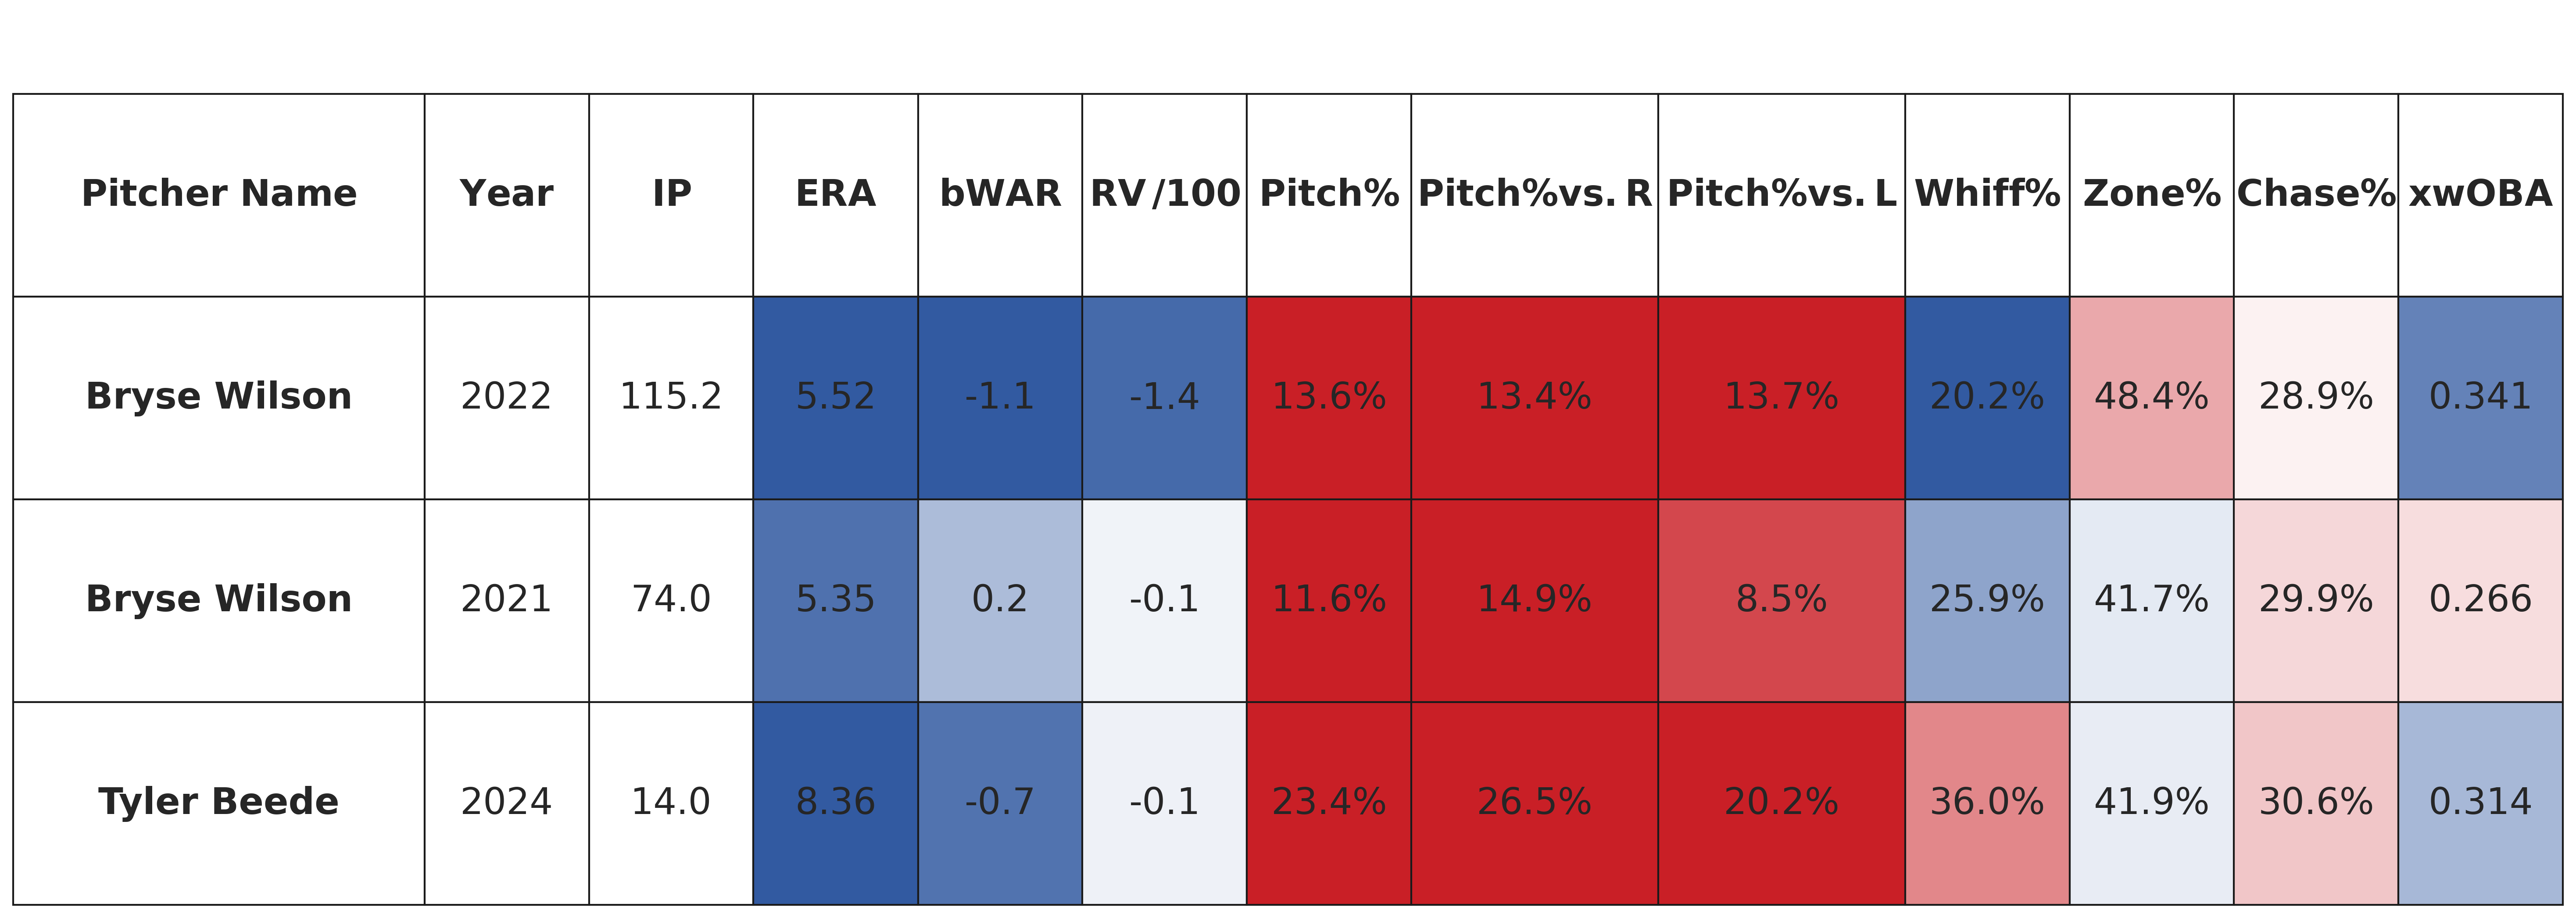

In [ ]:
# Merging our two formatting dictionaries we have used so far
ultimate_format_dict = {**format_stats_dict, **pitch_stats_dict}

def results_chart(playername, year, pitchtype, ax, fontsize:int=20):
    # Creating our dataframe
    df = result_table_df(playername, year, pitchtype)
    color_list_df = get_cell_colors_comp(df, df_statcast_group, color_stats, cmap_sum, cmap_sum_r, pitchtype)
    df_plot = plot_pitch_format(df, comp_results_table_columns)

    # Create a table plot with the DataFrame values and specified column labels
    table_plot = ax.table(cellText=df_plot.values, colLabels=comp_results_table_columns, cellLoc='center',
                        bbox=[0, -0.1, 1, 1],
                        colWidths=[2.5, 1, 1, 1, 1, 1, 1, 1.5, 1.5, 1, 1, 1, 1, 1, 1],
                        cellColours=color_list_df)

    # Disable automatic font size adjustment and set the font size
    table_plot.auto_set_font_size(False)
    table_plot.set_fontsize(fontsize)

    # Scale the table plot
    table_plot.scale(1, 0.5)

    # Correctly format the new column names using LaTeX formatting
    new_column_names = ['$\\bf{Pitcher\\ Name}$'] + ['$\\bf{Year}$'] + [ultimate_format_dict[x]['table_header'] if x in ultimate_format_dict else '---' for x in comp_results_table_columns[2:]]

    # Update the table headers with the new column names
    for i, col_name in enumerate(new_column_names):
        table_plot.get_celld()[(0, i)].get_text().set_text(col_name)

    # Bold the first column in the table
    for i in range(len(df_plot)):
        table_plot.get_celld()[(i+1, 0)].get_text().set_fontweight('bold')

    # Remove the axis
    ax.axis('off')

results_chart(ex_pitchername, ex_year, ex_pitchtype, ax=plt.subplots(figsize=(25, 8))[1])

### Generating the Pitch Similarity Graphic

This is a similar process as it was to create the general graphic, again using gridspec for the layout and matplotlib to generate the final graphic.

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.01iteration/s]


Converting Data to Dataframe.


<IPython.core.display.Javascript object>

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  2.82iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 11.89iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 11.82iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00,  6.76iteration/s]


Converting Data to Dataframe.
Gathering Player Data
Gathering Player Data
Gathering Player Data


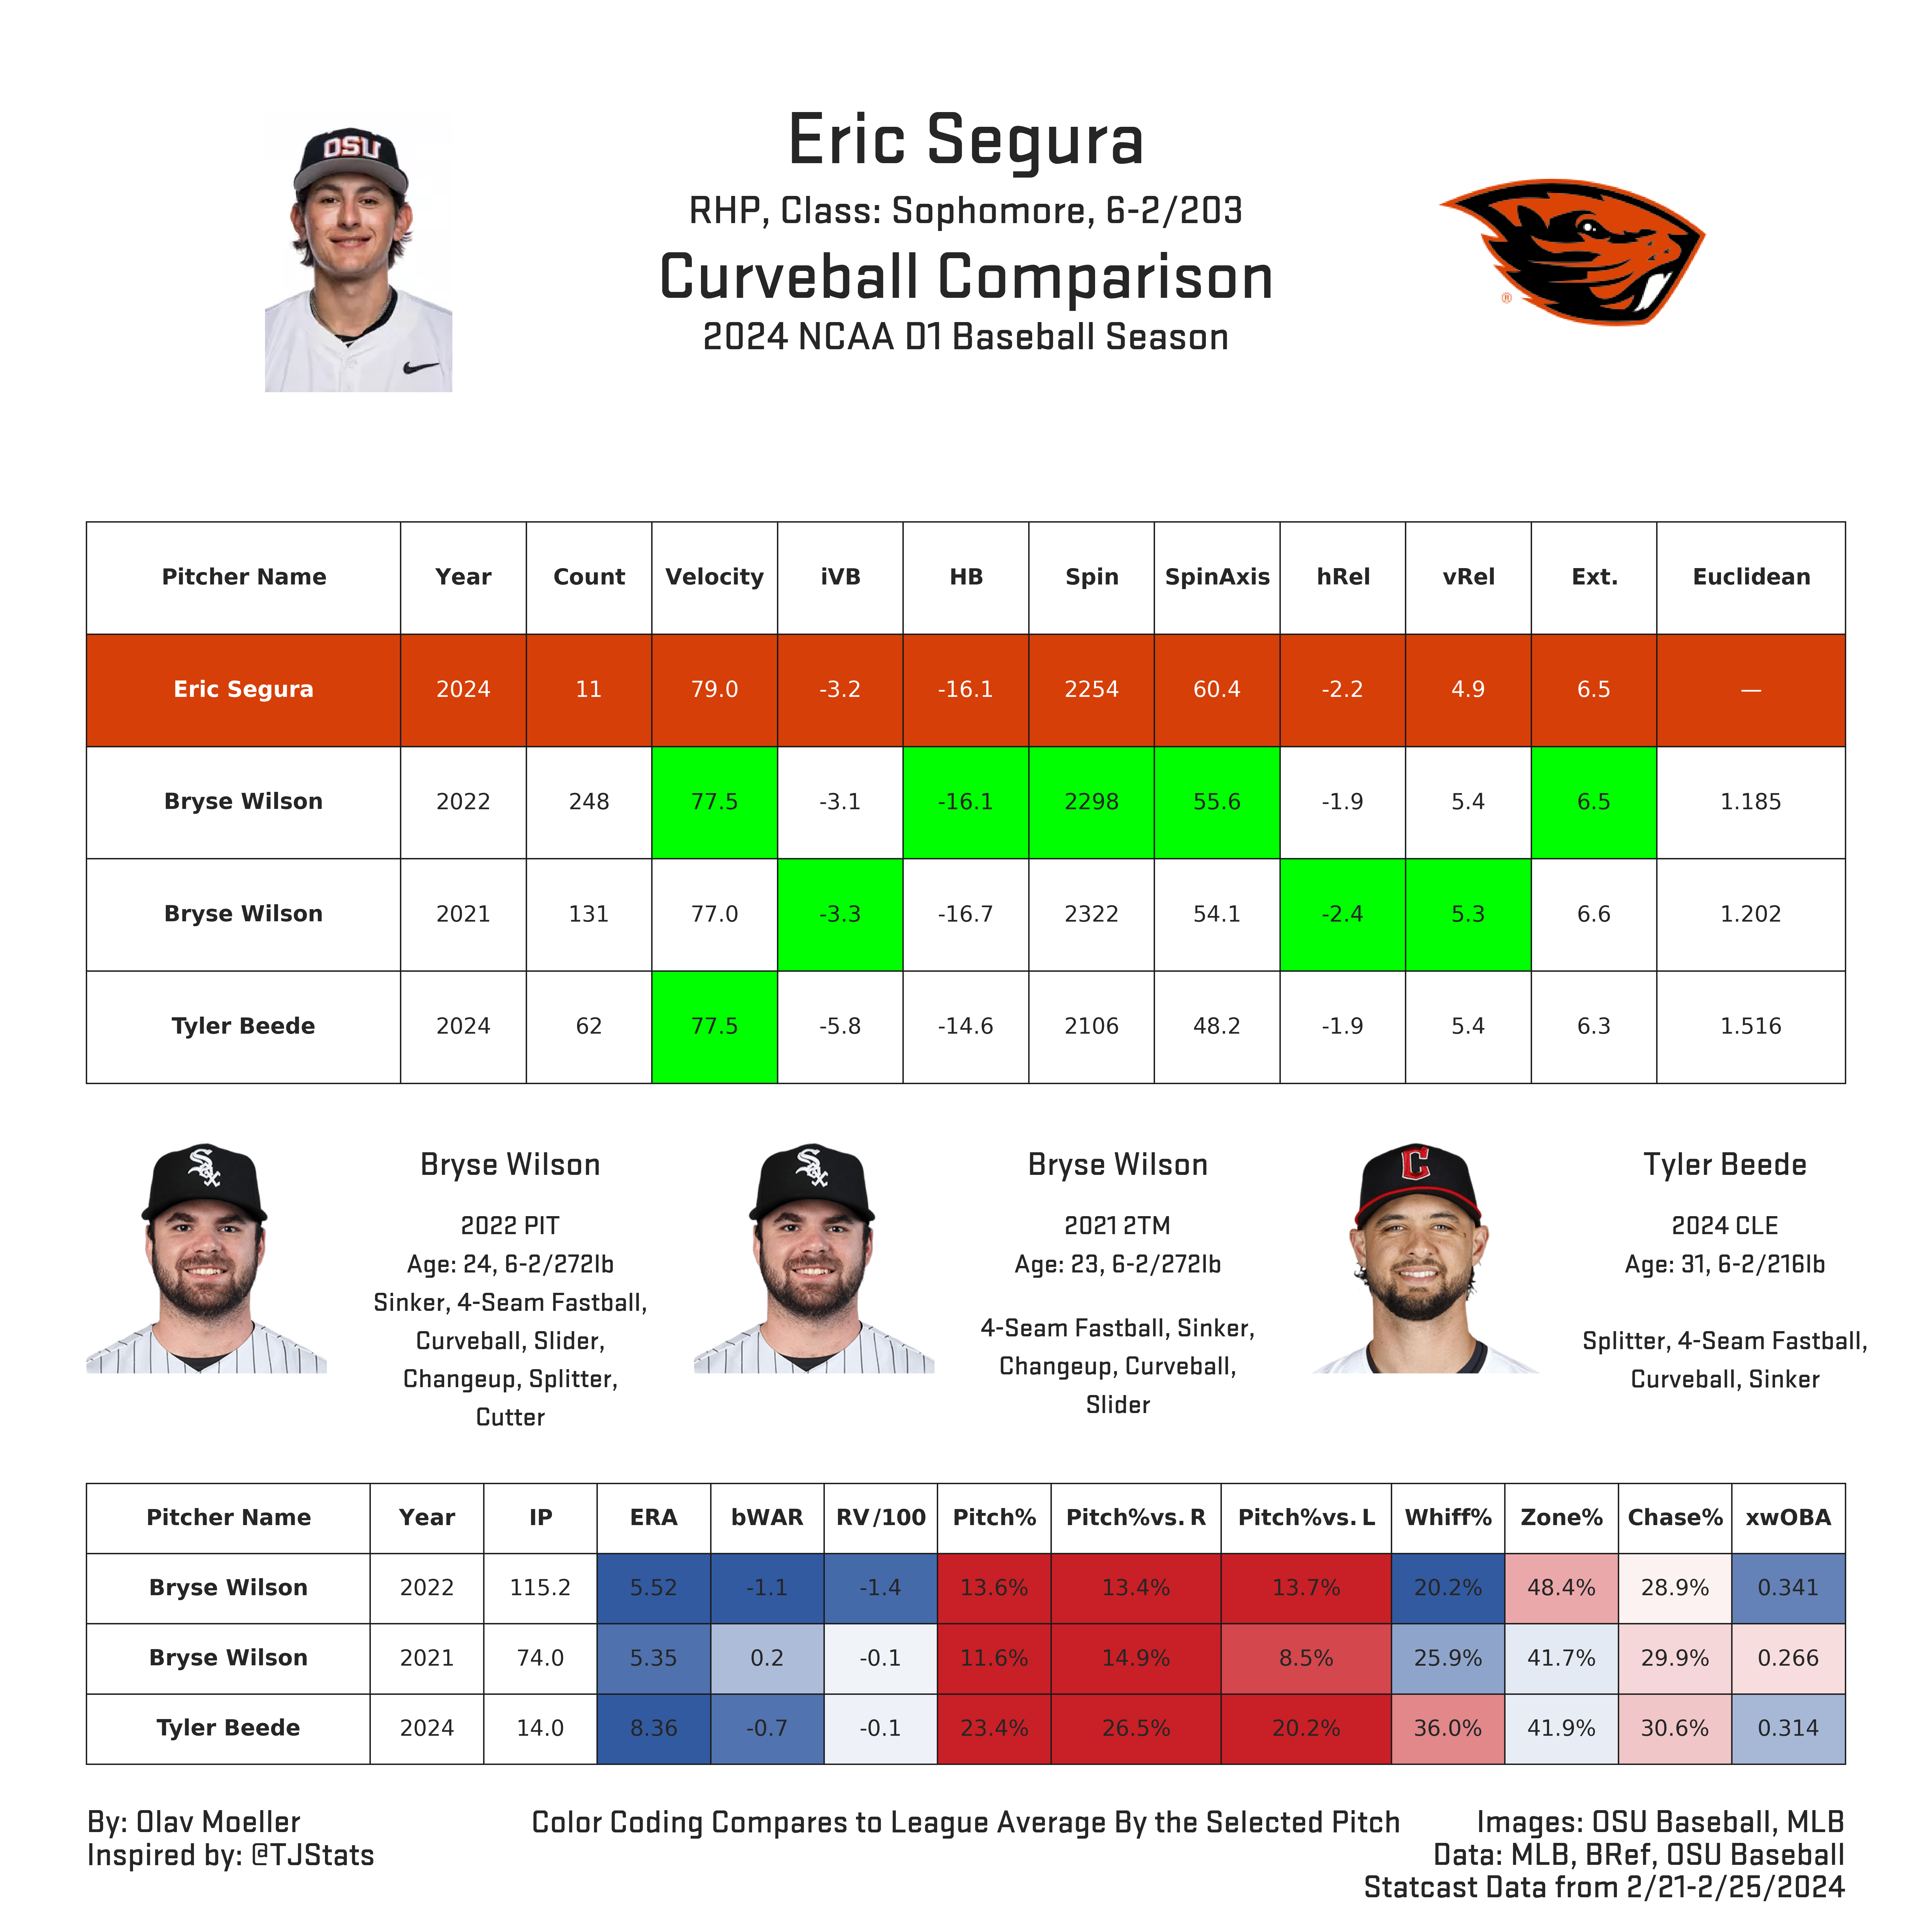

In [ ]:
def similarity_graphic(playername, year, pitchtype):
    # Create a 20 by 20 figure
    df = player_year_data(playername, year)
    fig = plt.figure(figsize=(20, 20))

    # Create a gridspec layout with 8 columns and 6 rows
    # Include border plots for the header, footer, left, and right
    gs = gridspec.GridSpec(6, 8,
                        height_ratios=[2,20,40,20,20,8],
                        width_ratios=[1,18,18,18,18,18,18,1])

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1,1:3])
    ax_comp_bio = fig.add_subplot(gs[1,3:5])
    ax_logo = fig.add_subplot(gs[1,5:7])

    ax_metric_table = fig.add_subplot(gs[2,1:7])

    ax_mlb_headshot_1 = fig.add_subplot(gs[3,1:2])
    ax_mlb_bio_1 = fig.add_subplot(gs[3,2:3])
    ax_mlb_headshot_2 = fig.add_subplot(gs[3,3:4])
    ax_mlb_bio_2 = fig.add_subplot(gs[3,4:5])
    ax_mlb_headshot_3 = fig.add_subplot(gs[3,5:6])
    ax_mlb_bio_3 = fig.add_subplot(gs[3,6:7])

    ax_result_table = fig.add_subplot(gs[4,1:7])

    ax_footer = fig.add_subplot(gs[-1,1:7])
    ax_header = fig.add_subplot(gs[0,1:7])
    ax_left = fig.add_subplot(gs[:,0])
    ax_right = fig.add_subplot(gs[:,-1])

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Define the player's link that can be called for the functions
    link = get_player_link(playername=playername, year=year)

    # Making the pitch similarity list so it is easily callable
    sim = pitch_similarity(playername=playername, year=year)

    # Define our 3 MLB players so we can find their information
    pitcher1 = sim.loc[sim['pitch_type'] == pitchtype].reset_index(drop=True).loc[0,'pitcher_name']
    year1 = sim.loc[sim['pitch_type'] == pitchtype].reset_index(drop=True).loc[0,'year']
    pitcher2 = sim.loc[sim['pitch_type'] == pitchtype].reset_index(drop=True).loc[1,'pitcher_name']
    year2 = sim.loc[sim['pitch_type'] == pitchtype].reset_index(drop=True).loc[1,'year']
    pitcher3 = sim.loc[sim['pitch_type'] == pitchtype].reset_index(drop=True).loc[2,'pitcher_name']
    year3 = sim.loc[sim['pitch_type'] == pitchtype].reset_index(drop=True).loc[2,'year']

    # Call the functions
    fontsize = 16

    metric_table(playername=playername, year=year, pitchtype=pitchtype, ax=ax_metric_table, fontsize=fontsize)
    results_chart(playername=playername, year=year, pitchtype=pitchtype, ax=ax_result_table, fontsize=fontsize)

    get_headshot(link=link, ax=ax_headshot)
    comp_bio(playername=playername, year=year, pitchtype=pitchtype, link=link, ax=ax_comp_bio)
    logo(ax=ax_logo)

    get_mlb_headshot(playername=pitcher1, ax=ax_mlb_headshot_1)
    mlb_bio(playername=pitcher1, year=year1, ax=ax_mlb_bio_1)
    get_mlb_headshot(playername=pitcher2, ax=ax_mlb_headshot_2)
    mlb_bio(playername=pitcher2, year=year2, ax=ax_mlb_bio_2)
    get_mlb_headshot(playername=pitcher3, ax=ax_mlb_headshot_3)
    mlb_bio(playername=pitcher3, year=year3, ax=ax_mlb_bio_3)

    # Add footer text
    ax_footer.text(0, 1, 'By: Olav Moeller\nInspired by: @TJStats', ha='left', va='top', fontsize=24, font=stratum)
    ax_footer.text(0.5, 1, 'Color Coding Compares to League Average By the Selected Pitch', ha='center', va='top', fontsize=24, font=stratum)
    ax_footer.text(1, 1, 'Images: OSU Baseball, MLB\nData: MLB, BRef, OSU Baseball\nStatcast Data from 2/21-2/25/2024', ha='right', va='top', fontsize=24, font=stratum)

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Downloading each plot
    plt.savefig(f"pitching_comparison_{playername.split(sep=' ')[1]}_{pitchtype}.png")

similarity_graphic(ex_pitchername, ex_year, ex_pitchtype)

### Generating Multiple Similarity Graphics

If we want to see a pitcher's full arsenal compared with mlb, we can run the function iteratively across the pitches they throw, as seen below.

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  3.26iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 11.55iteration/s]


Converting Data to Dataframe.


<IPython.core.display.Javascript object>

This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:01<00:00,  3.21iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.08iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.02iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.56iteration/s]


Converting Data to Dataframe.
Gathering Player Data
Gathering Player Data
Gathering Player Data


KeyboardInterrupt: 

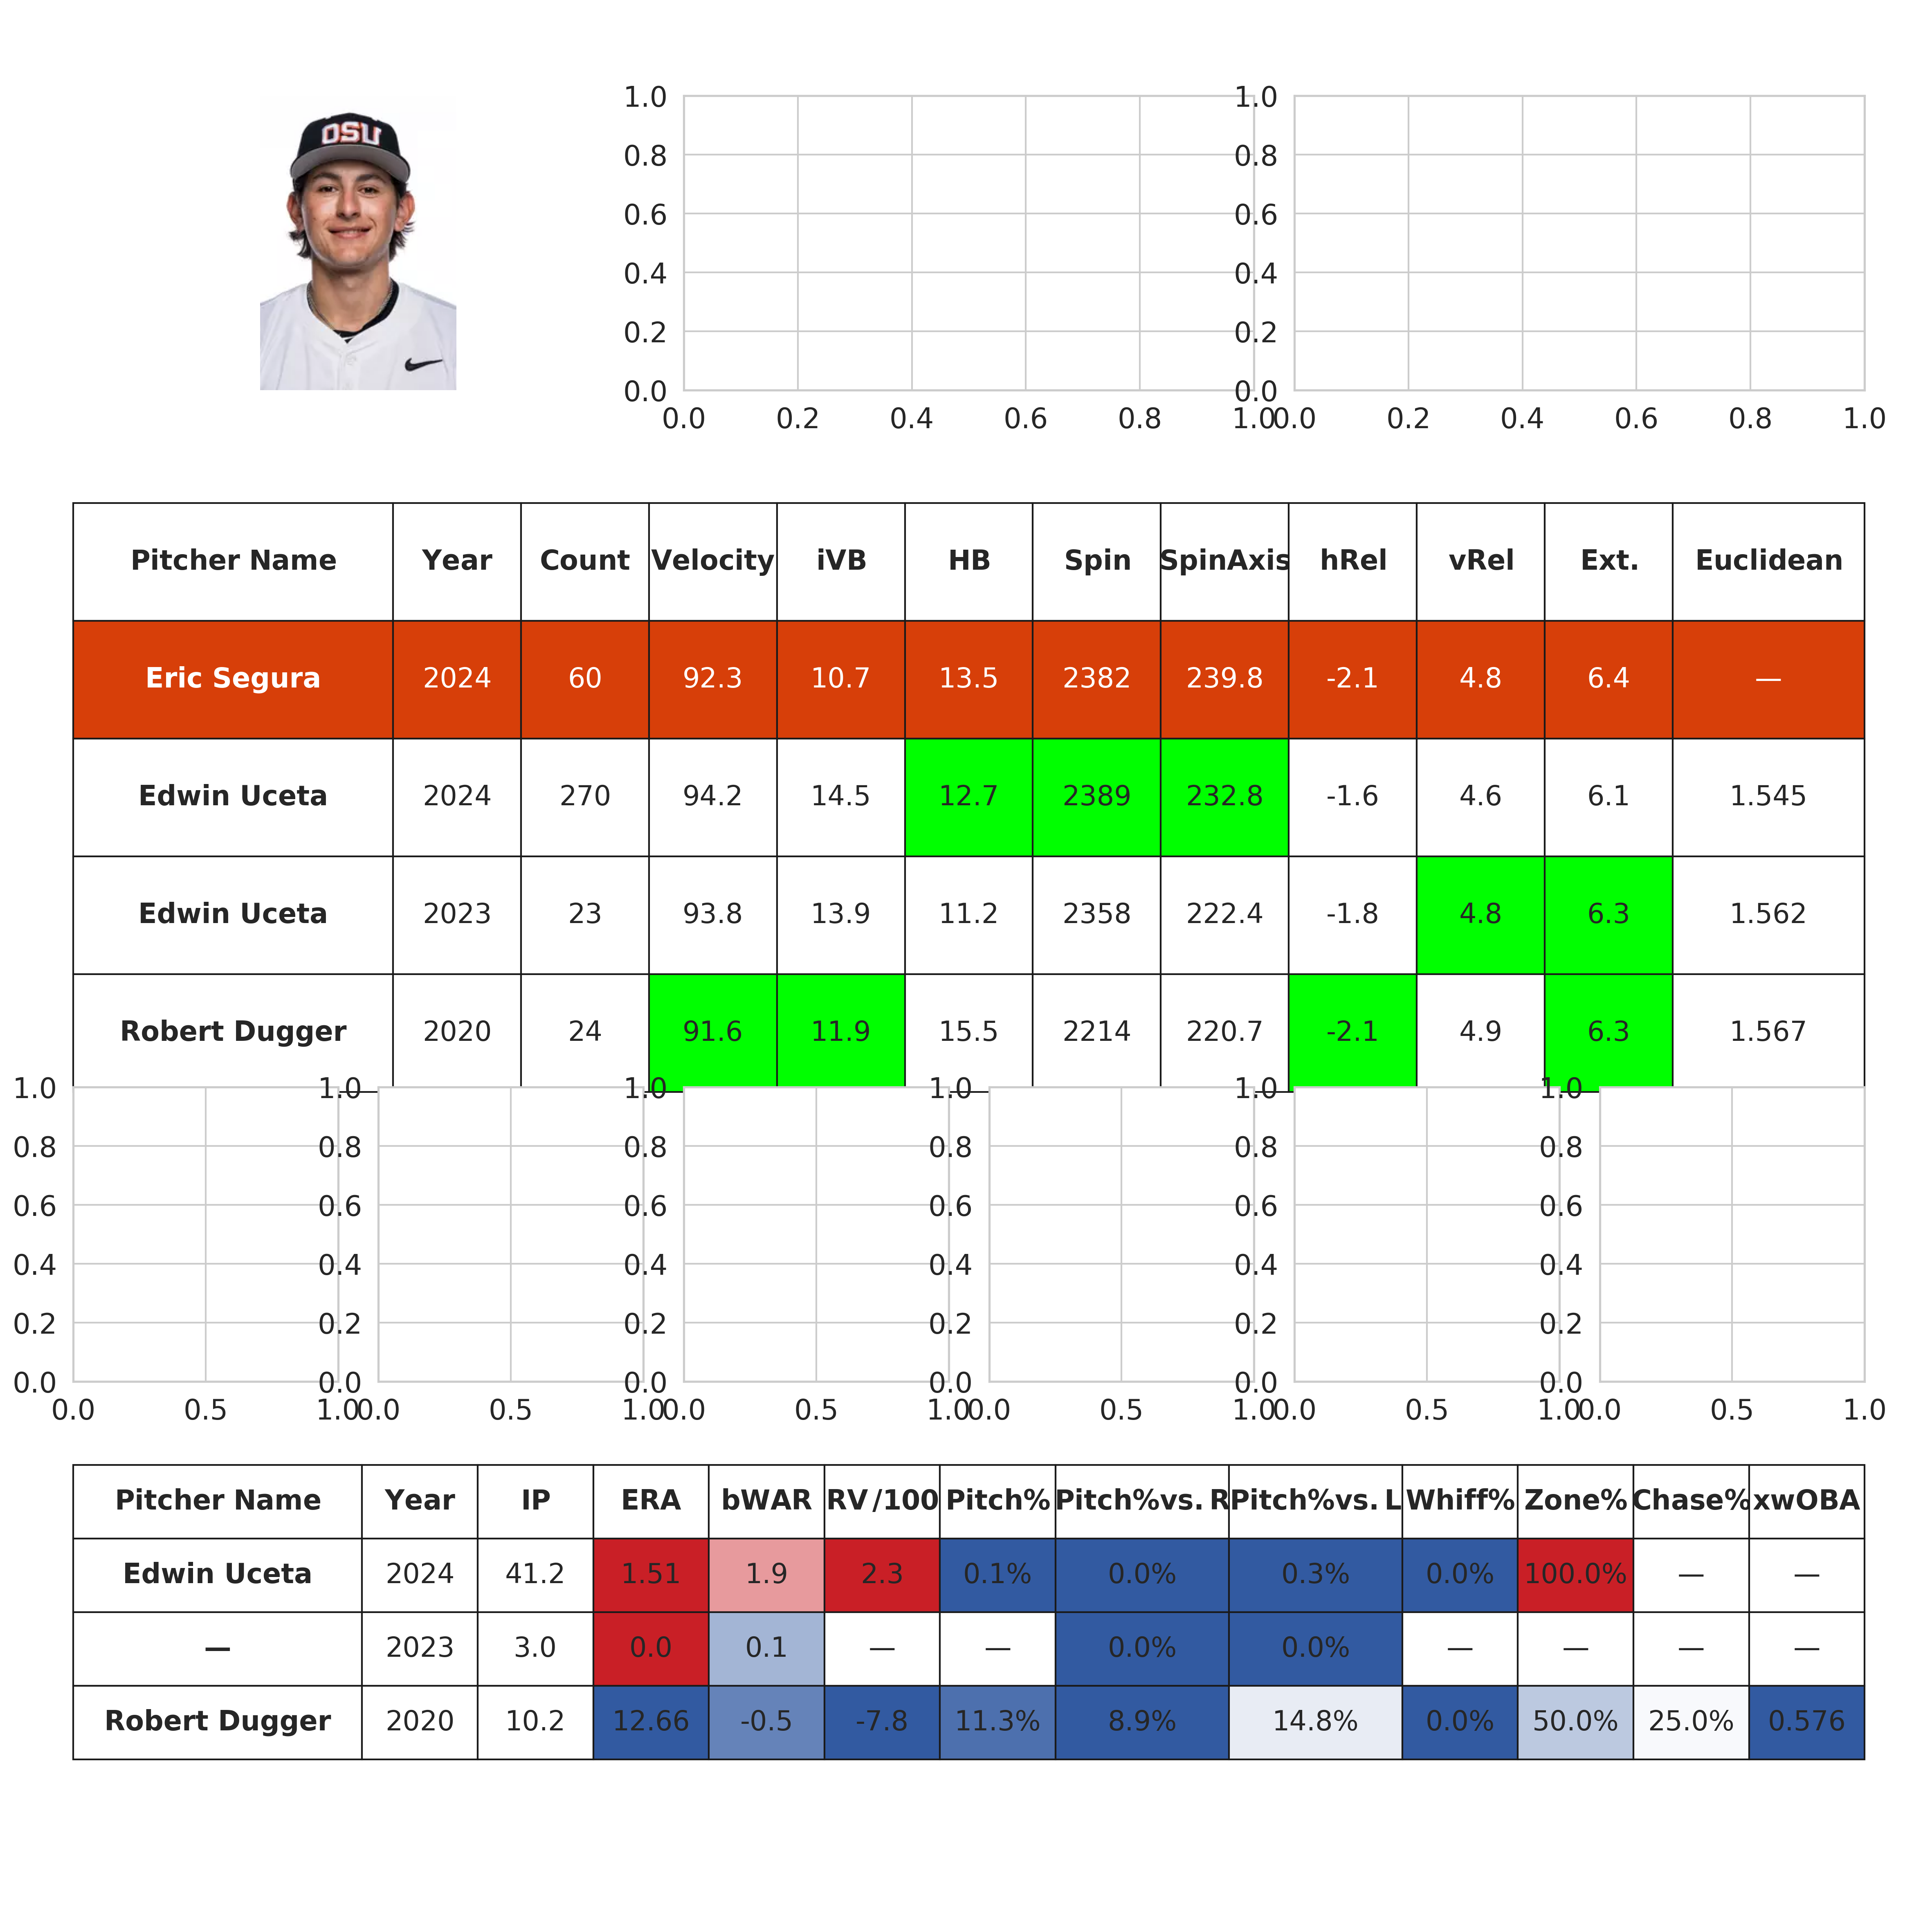

In [ ]:
def arsenal_comparison(playername, year):
    df = player_year_data(playername, year)
    pitch_type_list = df['pitch_type'].unique().tolist()
    new_list = [x for x in pitch_type_list if x is not None]
    for i in new_list:
        similarity_graphic(playername=playername, year=year, pitchtype=i)

arsenal_comparison(ex_pitchername, ex_year)

## Conclusions

### Overall Thoughts

This was a fascinating project to work on, as I had never worked with python before, let alone any coding really outside of two semesters of data analysis with R.

I think it was useful to start with a graphic/idea that wasn't fully original, as I was able to really go over the code and understand how it works the way that it does. Thomas Nestico, whose summary graphics were the main inspiration for this whole project, is someone who I greatly appreciate in making his code public. From first seeing the graphics he made, I knew I liked the information they were able to convey, and I wanted to adapt this to OSU's statcast data. Once I found out that OSU had games where the statcast data was public, I realized I could make it happen.

Taking code and adapting it to the resources I had and trying to understand syntax and learning good processes has been a very very informative process, and I now understand python much more thoroughly than before, although that didn't necessarily take too much. As I progressed working through this project, I eventually was able to make more individualized parts, which was interesting, and frustrating at times, but very rewarding. Taking the pitch plinko that exists on Baseball Savant and turning it into my own chart was very satisfying. Similarly, working on the pitch comparison data, which is an idea I haven't seen done before (although it likely has, I just haven't looked very hard), and using my mathematical knowledge to determine a way to do it and then creating a graphic, was a good test that showed me that I can take data and manipulate it in the ways I want, and produce a visualization sharing that data.

### Pitch Tagging Discussion

One thing to note is that in this example, when looking at the chart for Eric Segura's sinker, Edwin Uceta is oddly omitted from the results chart. This is inconvenient, as his sinker was the most similar to Segura's, and we would like to look at it. The specific issue is a discrepency between the MLB API tagging of his pitch and Baseball Savant's tagging, which is called through pybaseball's scraping, however it raises a more general issue, which is pitch tagging as a whole.



Pitch tagging (defining what pitch is thrown) is often subjective, with MLB indicating that they default to what the pitcher himself calls it, regardless of its movement profile compared to a typical example of that pitch type. For example, Josh Hader calls his main pitch a Sinker, although it is much more similar in its IVB and velocity to a Four-Seam, yet it is considered a sinker in their documentation. I think this is what lead to the problem in the Edwin Uceta example, as his primary pitch is called a sinker in MLB API and a Four-Seam in Savant.


To be complete, I likely should have found the distance between our OSU pitcher's pitches and any pitch in MLB, regardless of classification, to consider whether his pitch was more similar to one tagged differently. However this is a small difference, and likely wouldn't add many closer values, and would take a good amount more code that I didn't think to do when I started.


One last note on pitch tagging: it is often incorrect when done by MLB's neural network, and as such pitch classification can be a little bit odd. For example, if we return to Nelson Keljo's general summary generated earlier. There are a two very clear clusters, tagged as 4-seam fastballs and sliders. This makes sense. Then, there are a few outlier pitches, that don't seem to belong to any cluster. This leads to a few stray pitches labelled fastball and slider, that may be either a tracking mistake or a completely new pitch. This will affect overall aggregated metrics of a pitch type, especially in low sample sizes like this, which hurts our ability to compare pitch types.

Another example of this is in Eric Segura's data that we have looked at extensively. The data indicates that he threw 60 sinkers, and 3 4-seam fastballs. I would be inclined to think that those pitches tagged as 4-seams were also sinkers, given their similar movement, releases, spins, and velocities. However, we can't know this unless the pitcher themself specifically says what type of pitch they threw, and as such we may be giving the pitcher credit for a new pitch type that they aren't even intending to throw. This, and the outliers for Nelson Keljo, can be manually adjusted or removed, but doing that on a case-by-case basis would be time consuming and difficult.

This is just a limitation of the data that is important to be aware of, and something that is important to think about when putting stock into automated pitch tagging.

### Skills learned

Through this project, I have learned or enhanced a number of skills useful for my future data analysis, including:

*   Website Scraping (New)
*   Data Manipulation
*   Python syntax (New)
  *   Pandas, Numpy, MLB API, BeautifulSoup, matplotlib
*   Data Visualization
*   Grit and ability to figure things out

I've defnitely learned a ton about how to undergo a project like this, and feel much more prepared and competent when it comes to coding and baseball data analysis. As someone who has never done much coding before, especially outside of assignments, this was very new, but a great learning opportunity.

I also made an interesting discovery along the way, which was that MLB API has a different value for release point than Baseball Savant/statcast does. This was just something I noticed when attempting to view the same data from different methods, and found it odd. I even was able to point this out to others in the baseball statistics space, including people that work with both data grabbing methods, and they hadn't noticed the difference. This isn't an issue in my data, as all comparisons are between MLBAPI data, baseball savant isn't used for release point data at all, but it was an interesting note. Learning to look over data to that level and find issues like that is another thing I was able to leran from this project.





### Pitch Comparison Utility

While I do think there is a lot that can be learned from the pitch comparison graphics I was able to construct, the majority of that isn't discussed or shown. I have ideas for how to use it, specifically with regards to overall arsenal design, usage, and sequencing, but those ideas are more abstract and individualized, so they aren't able to appear on a mass produced graphic that works for a number of pitchers.

With more time and analysis, I would be able to provide usage of the data and the ability to turn it into something much more useful than just a graphic. The graphic does a good job of summarizing similar pitches, and their effectiveness, but any changes or additions or advice from there on is left to the reader for now.

Also, with the sample sizes as small as they are, the characteristics of the pitches haven't fully stabilized, and making infereces/assumptions from that small of a sample isn't necessarily that significant or useful. Eric Segura's sinker having 60 datapoints means that it is likely a useful comparison, but the comparison of a pitch with just 5 thrown won't tell us much. With access to more data than just 4 games from February, the very start of the season, I would be able to make comparisons that are much more relevant and useful, and likely better indicators of the pitcher's true metrics.

### End

Thank you for reading and engaging with this project! If you have questions or clarification, feel free to contact me and I am more than happy to elaborate on anything.